<h1>Сайты знакомств: анализ анкет</h1>
<h2>Часть первая: анкеты женщин</h2>

Предмет исследования - анкеты с сайта знакомств <a href="www.mheart.ru">Missing Heart</a>. Исследовано по 10000 анкет женщин из Москвы и Санкт-Петербурга от 18 до 70 лет. Выявлены различия и сходства по 17 параметрам.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

from transliterate import translit

In [2]:
# чтение данных
spbf = pd.read_json('spb_females_new.json')
mf = pd.read_json('moscow_females_final.json')

In [3]:
# очистка и преобразование данных

def normalize_partner_age(x):
    '''
        Привести желаемый возраст парнера к другому формату
    ''' 
    if ',' in str(x):
        x = x.split(',')[1]
        x = x.replace(' - ', '-').replace('год','').replace('лет','').strip()
        return x
    return ''

def avg_pa(x):
    '''
        Посчитать медианный возраст партнера
    '''
    if x:
        x1 = int(x.split('-')[0])
        x2 = int(x.split('-')[1])
        return np.median(range(x1, x2+1))
    return x

# записать желаемый возраст партнера в отдельную колонку
mf['partnerAge'] = mf['want_to_meet'].apply(normalize_partner_age)
spbf['partnerAge'] = spbf['want_to_meet'].apply(normalize_partner_age)


def normalize_partner_sex(x):
    '''
        Привести желаемый пол парнера к другому формату
    '''
    
    x = str(x)
    
    if 'или' in x:
        return 'М и Ж'
    if 'с парнем' in x:
        return 'M'
    if 'с девушкой':
        return 'Ж'
    return ''


def filter(df):
    '''
        Убрать из данных наименее полные записи
    '''
    df = df[(~df['processed'].isnull()) & (df['blocked']==0) & (df['selfAge'] > 0) & (df['selfAge'] <= 70)]
    df = df[(df['smoking']!='Отношение к курению:') & (df['drinking']!='Отношение к алкоголю:')]
    df = df[(df['material_conditions']!='Материальное положение:') & (df['children']!='Дети:')]
    df = df[(df['education']!='Образование:') & (df['build']!='Телосложение:') & (df['appearance']!='Внешность:')]
    
    df = df[~df['want_to_meet'].isnull()]
    
    df = df[~df['partnerAge'].str.contains('или')]
    
    df = df.reset_index()
    return df

# фильтруем данные
spbf = filter(spbf)
mf = filter(mf)

# ограничиваем данные 10.000 записей
mf = mf.iloc[:10000]
spbf = spbf.iloc[:10000]

# записываем границы возраста парнера и медиану в отдельные поля
mf['partnerAge_min'] = mf['partnerAge'].map(lambda x: int(x.split('-')[0]) if x else x)
mf['partnerAge_max'] = mf['partnerAge'].map(lambda x: int(x.split('-')[1]) if x else x)
mf['partnerAge_avg'] = mf['partnerAge'].map(avg_pa)

spbf['partnerAge_min'] = spbf['partnerAge'].map(lambda x: int(x.split('-')[0]) if x else x)
spbf['partnerAge_max'] = spbf['partnerAge'].map(lambda x: int(x.split('-')[1]) if x else x)
spbf['partnerAge_avg'] = spbf['partnerAge'].map(avg_pa)

# записываем желаемый пол партнера в отдельное поле
mf['partnerSex'] = mf['want_to_meet'].map(normalize_partner_sex)
spbf['partnerSex'] = spbf['want_to_meet'].map(normalize_partner_sex)

<h3>1. Имена</h3>

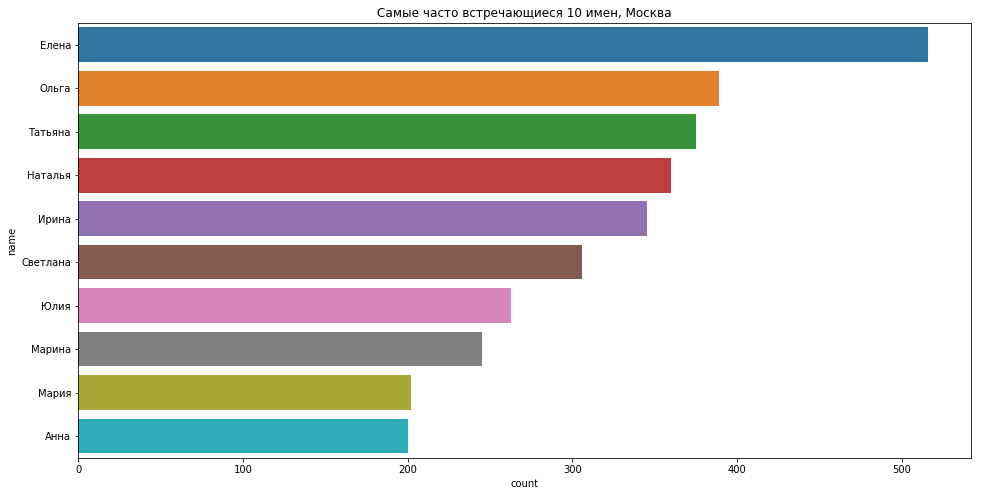

In [4]:
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.countplot(y='name', data=mf, order = mf['name'].value_counts().iloc[:10].index)
ax.set_title('Самые часто встречающиеся 10 имен, Москва'); 

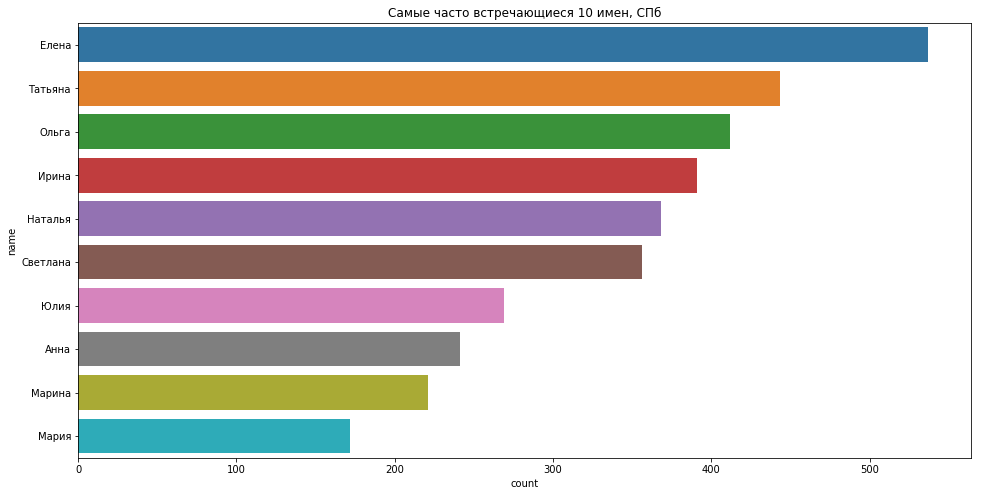

In [5]:
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.countplot(y='name', data=spbf, order = spbf['name'].value_counts().iloc[:10].index)
ax.set_title('Самые часто встречающиеся 10 имен, СПб'); 

Итак, в целом имена в топ-10 одинаковы в обоих городах, разница только в местах. Первое место в обоих случаях занимает имя "Елена".

Далее производим нормализацию имен, состоящую из следующих шагов:

* транслитерация в кириллицу с последующей коррекцией
* замена ё на е
* отсечение второго и последующих компонентов имени (фамилий и пр.)
* транслитерация иностранных вариантов и приведение их к базовым
* приведение некоторых уменьшительно-ласкательных форм к базовым

Это позволяет слить большую часть имен-дубликатов. Последний шаг производится только для распространенных имен. Не учитываются низкочастотные уменьшительно-ласкательные формы (например, к форме "Елена" приводятся только имена "Лена", "Элен", "Хелен" и их транслитерированные варианты).

In [6]:
def normalize_name(name):
    '''
        Привести имя к стандартной форме
    '''
    
    female_names = {
        'олга': 'ольга',
        'наталия': 'наталья',
        'татияна': 'татьяна',
        'татяна': 'татьяна',
        'дария': 'дарья',
        'натали': 'наталья',
        'оля': 'ольга',
        'наташа': 'наталья',
        'ната': 'наталья',
        'натали': 'наталья',
        'таня': 'татьяна',
        'тата': 'татьяна',
        'марья': 'мария',
        'мари': 'мария',
        'маша': 'мария',
        'мэри': 'мария',
        'женя': 'евгения',
        'даша': 'дарья',
        'саша': 'александра',
        'ксюша': 'ксения',
        'лена': 'елена',
        'элен': 'елена',
        'хелен': 'елена',
        'ира': 'ирина',
        'света': 'светлана',
        'юля': 'юлия',
        'аня': 'анна',
        'анюта': 'анна',
        'катя': 'екатерина',
        'катерина': 'екатерина',
        'настя': 'анастасия',
        'надя': 'надежда',
        'люба': 'любовь',
        'вика': 'виктория',
        'лиза': 'елизавета',
        'лера': 'валерия',
        'софия': 'софья',
        'лара': 'лариса',
        'тоня': 'антонина',
        'крис': 'кристина',
        'люда': 'людмила',
        'галя': 'галина',
        'валя': 'валентина'
    }
    
    normalized_name = name.lower().strip()
    if ' ' in normalized_name:
        normalized_name = normalized_name.split(' ')[0]
    normalized_name = normalized_name.replace('ё', 'е')
    normalized_name = translit(normalized_name, 'ru')
    normalized_name = normalized_name.replace('ыу', 'ю')
    normalized_name = normalized_name.replace('ыа', 'я')
    normalized_name = normalized_name.replace('иа', 'ия')
    
    if normalized_name in female_names:
        normalized_name = female_names[normalized_name]
        
    normalized_name = normalized_name[0].upper() + normalized_name[1:]
        
    return normalized_name

In [7]:
mf['normalized_name'] = mf['name'].map(normalize_name)
spbf['normalized_name'] = spbf['name'].map(normalize_name)

После нормализации имеем:

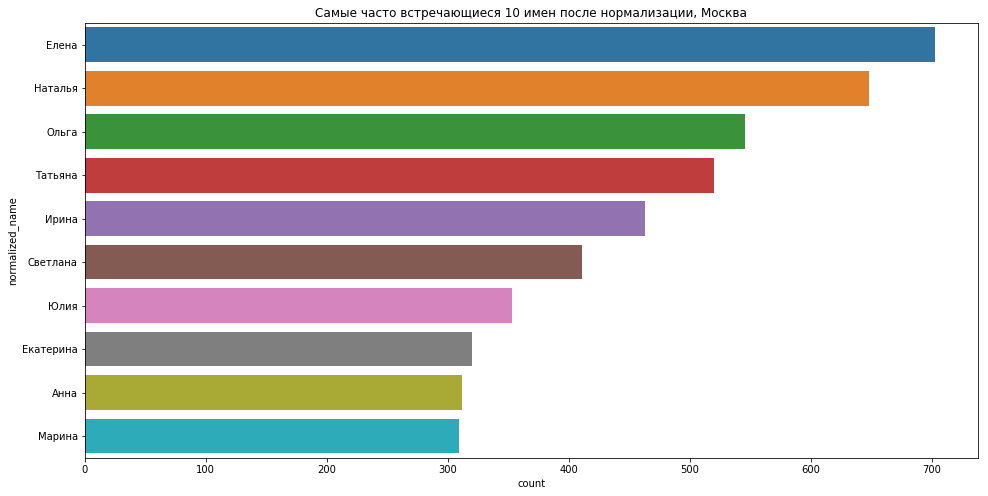

In [8]:
f, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y='normalized_name', data=mf, order=mf['normalized_name'].value_counts().iloc[:10].index)
ax.set_title('Самые часто встречающиеся 10 имен после нормализации, Москва'); 

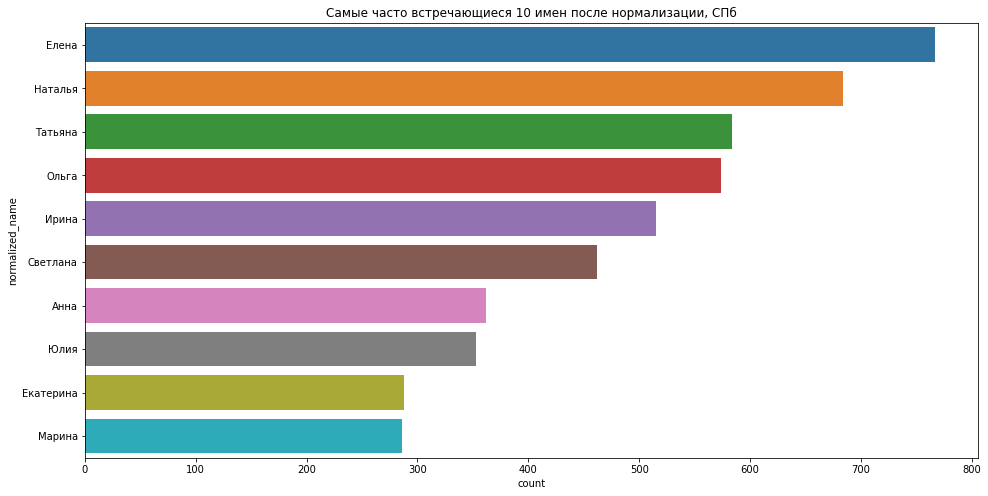

In [9]:
f, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y='normalized_name', data=spbf, order=spbf['normalized_name'].value_counts().iloc[:10].index)
ax.set_title('Самые часто встречающиеся 10 имен после нормализации, СПб'); 

После нормализации Мария выпала из топ-10 в обоих случаях, вместо нее появилась Екатерина. В обоих городах топ-10 вновь одинаков, меняется только порядок. В обоих городах лидеры одинаковы - Елена и Наталья. Наталья значительно улучшила свои результаты, причиной чему является слияние вариантов "Наталья" и "Наталия" в один. Третье место делят Ольга (Москва) и Татьяна (СПб). Впрочем, Ольга в СПб лишь ненамного отстает от Татьяны.

In [10]:
print("Доля анкет с именами из топ-10, Москва: {0:2.2f}%".format(sum(100 * mf['normalized_name'].value_counts()[:10] / len(mf))))

Доля анкет с именами из топ-10, Москва: 45.85%


In [11]:
print("Доля анкет с именами из топ-10, СПб: {0:2.2f}%".format(sum(100 * spbf['normalized_name'].value_counts()[:10] / len(spbf))))

Доля анкет с именами из топ-10, СПб: 48.75%


<h3>2. Знак зодиака</h3>

In [12]:
def show_percent_ordered(df, x, title, limit=0):
    '''
        Показать гистограмму в процентах, отсортированную по убыванию 
    '''

    f, ax = plt.subplots(figsize=(16, 8))
    if limit == 0:
        sns.barplot(x=x, y=x, orient="v", data=df, estimator=lambda x: len(x) / len(df) * 100,
                    order=df[x].value_counts().index)
    else:
        sns.barplot(x=x, y=x, orient="v", data=df, estimator=lambda x: len(x) / len(df) * 100,
                    order=df[x].value_counts().iloc[:limit].index)
    ax.set(ylabel="Percent")
    ax.set_title(title)

/home/hrutr/.virtualenvs/dating/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


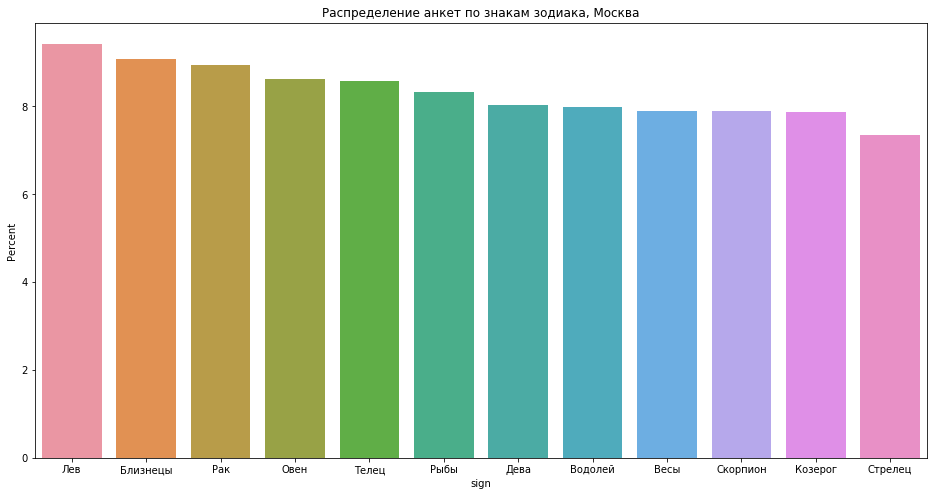

In [13]:
show_percent_ordered(mf, 'sign', 'Распределение анкет по знакам зодиака, Москва')

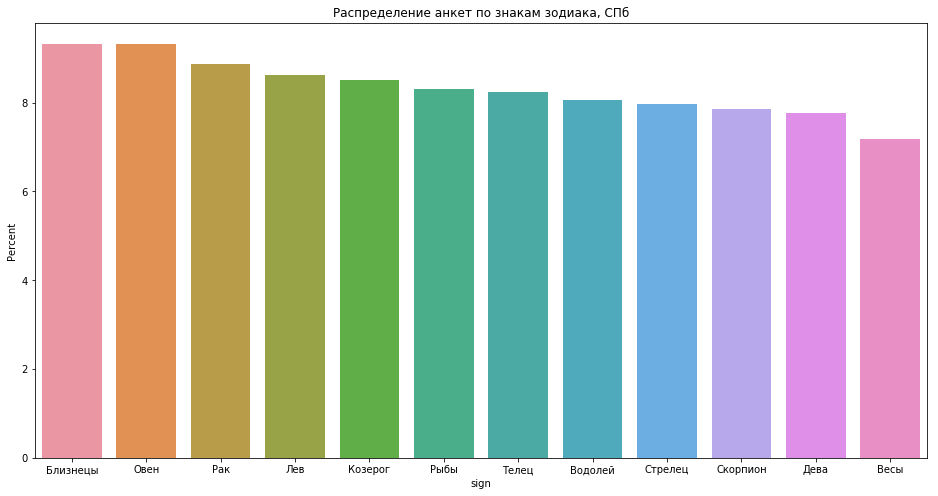

In [14]:
show_percent_ordered(spbf, 'sign', 'Распределение анкет по знакам зодиака, СПб')

Итак, в Москве преобладают рожденные летом и весной (первая тройка принадлежит летним знакам, вторая тройка - весенним), в СПб эта закономерность смазана - на 1-м, 2-м и 4-м месте летние знаки, на 2-м - весенний.

<h3>3. Возраст</h3>

In [15]:
mf['selfAge'] = mf['selfAge'].astype(float)

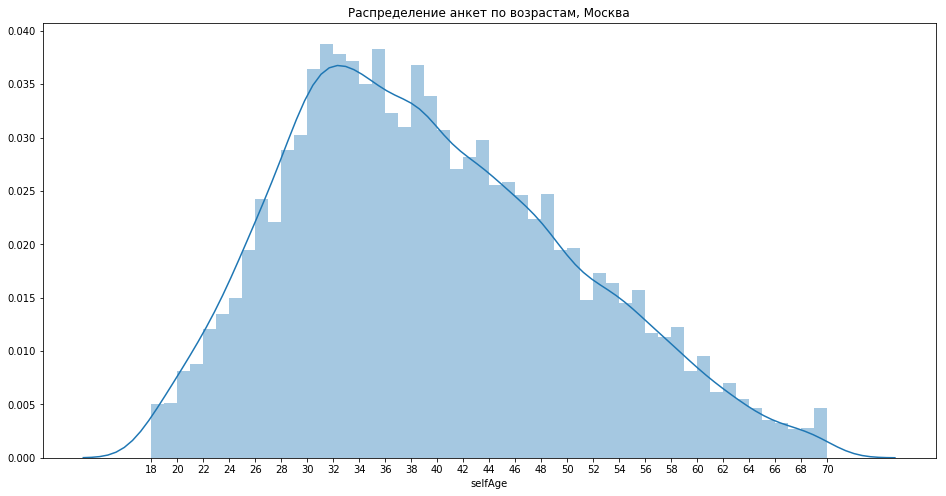

In [16]:
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(mf['selfAge'], bins=70-18, kde=True, rug=False)
ax.set_title('Распределение анкет по возрастам, Москва')
ax.set_xticks(np.arange(18, 71, 2));

In [17]:
print ("Медианный возраст анкет, Москва: {0:2.1f} лет".format(mf['selfAge'].median()))

Медианный возраст анкет, Москва: 38.0 лет


In [18]:
print ("Средний возраст анкет, Москва: {0:2.2f} лет".format(mf['selfAge'].mean()))

Средний возраст анкет, Москва: 39.39 лет


In [19]:
print ("Стандартное отклонение по возрасту, Москва: {0:2.2f} ".format(mf['selfAge'].std()))

Стандартное отклонение по возрасту, Москва: 10.98 


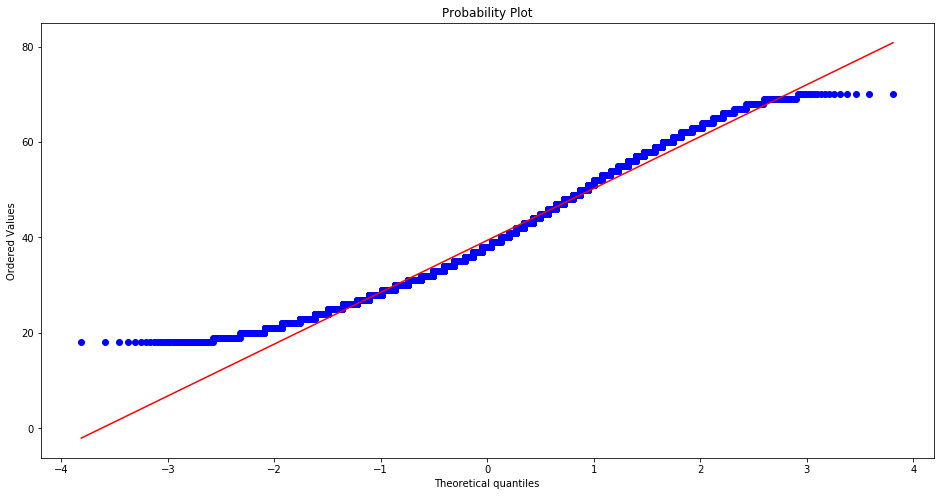

In [20]:
# qq plot распределения возраста, Москва
from scipy import stats

f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(mf['selfAge'], plot=plt)
plt.show()

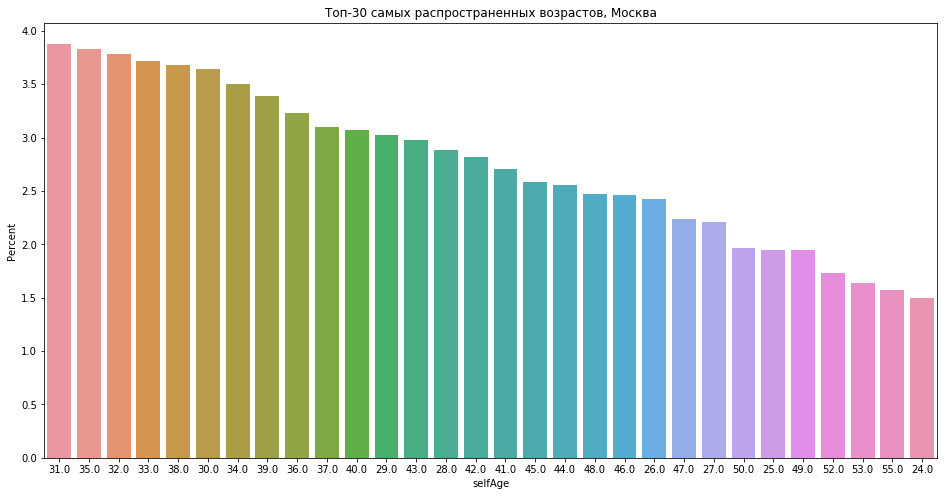

In [21]:
show_percent_ordered(mf, 'selfAge', 'Топ-30 самых распространенных возрастов, Москва', limit=30)

Можно видеть, что в Москве в топ-10 представлены исключительно анкеты от 30 до 40 лет.

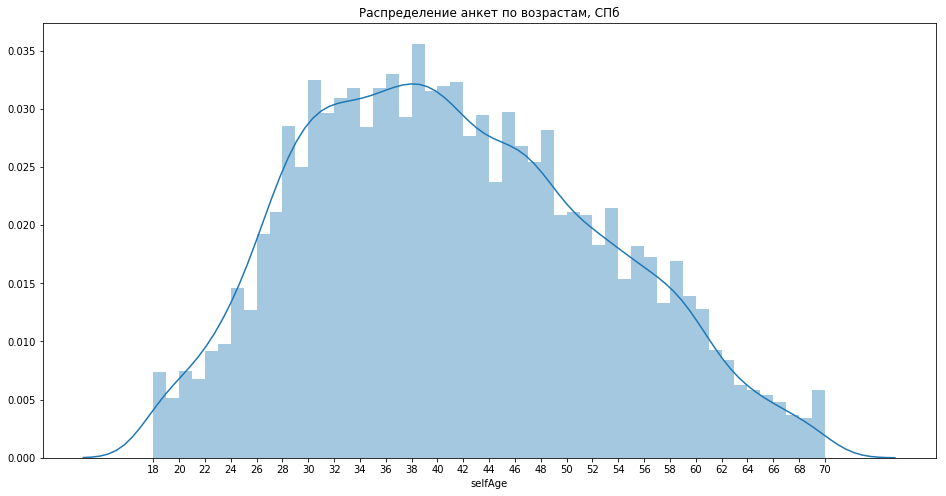

In [22]:
spbf['selfAge'] = spbf['selfAge'].astype(float)
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(spbf['selfAge'], bins=70-18, kde=True, rug=False)
ax.set_title('Распределение анкет по возрастам, СПб')
ax.set_xticks(np.arange(18, 71, 2));

In [23]:
print ("Медианный возраст анкет, СПб: {0:2.1f} лет".format(spbf['selfAge'].median()))

Медианный возраст анкет, СПб: 40.0 лет


In [24]:
print ("Средний возраст анкет, СПб: {0:2.2f} лет".format(spbf['selfAge'].mean()))

Средний возраст анкет, СПб: 41.04 лет


In [25]:
print ("Стандартное отклонение по возрасту, СПб: {0:2.2f} ".format(spbf['selfAge'].std()))

Стандартное отклонение по возрасту, СПб: 11.40 


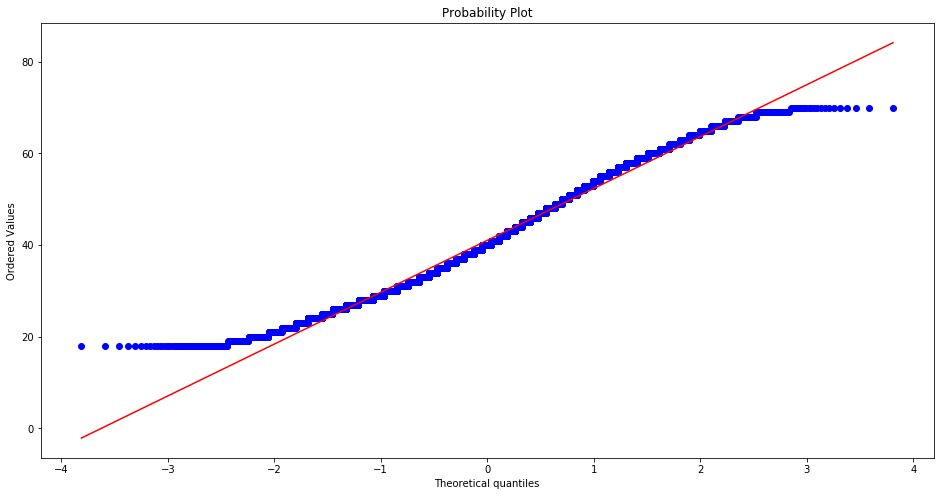

In [26]:
# qq plot распределения возраста, СПб
f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(spbf['selfAge'], plot=plt)
plt.show()

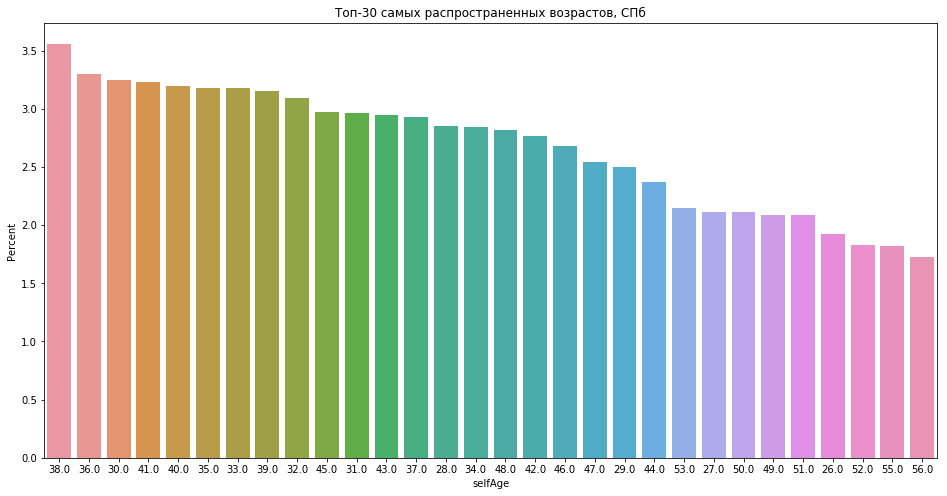

In [27]:
show_percent_ordered(spbf, 'selfAge', 'Топ-30 самых распространенных возрастов, СПб', limit=30)

В СПб в топ-10 видим возраст от 30 до 45 лет.

Можно сделать вывод, что средний возраст в анкетах из СПб в целом на несколько лет выше по сравнению с московскими анкетами.

Рассмотрим распределение самых популярных имен по возрастам.

In [28]:
def show_params_by_age(df, param, title, limit=0):

    if limit:
        values = list(df[param].value_counts()[:limit].index)    
    else:
        values = []
    
    params_age = []
    sdf = dict(df['selfAge'].value_counts())
    for k, v in df.groupby(['selfAge', param]).groups.items():
        if values:
            if k[1] in values:
                params_age.append({'age': k[0], param: k[1], 'percent': 100*len(v)/ sdf[k[0]]})
        else:
            params_age.append({'age': k[0], param: k[1], 'percent': 100*len(v)/ sdf[k[0]]})
    df_params_age = pd.DataFrame(params_age)
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.lineplot(x='age', y='percent', data=df_params_age, hue=param)
    ax.set_title(title)
    ax.set_xticks(np.arange(18, 81, 2))

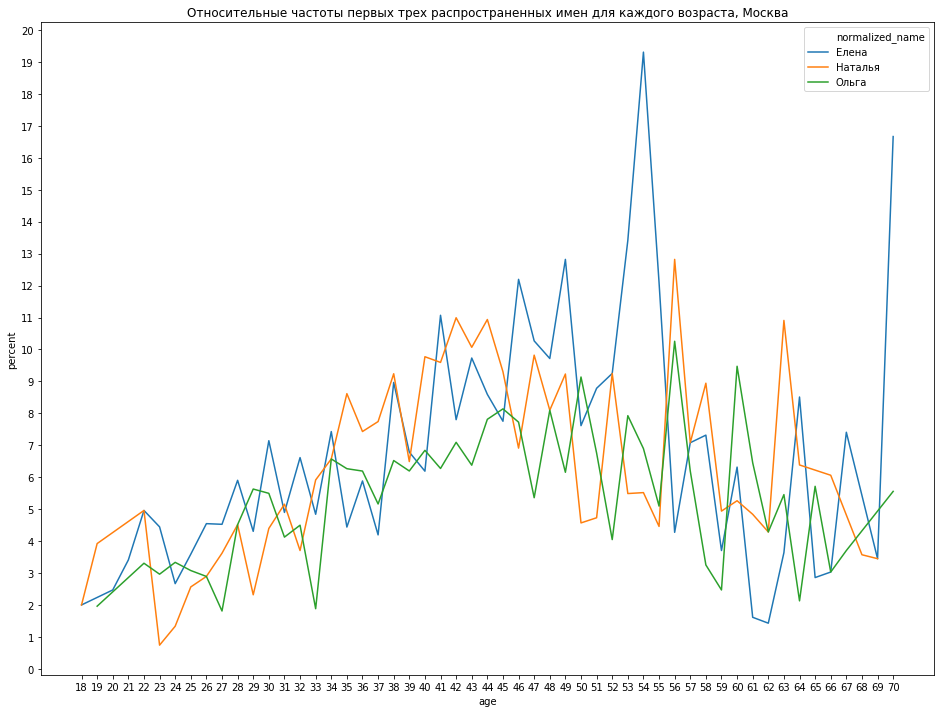

In [29]:
names_age = []
dict_vc = dict(mf['selfAge'].value_counts())
top_names = ['Елена', 'Наталья', 'Ольга']
for k, v in mf.groupby(['selfAge','normalized_name']).groups.items():
    if k[1] in top_names:
        names_age.append({'age': k[0], 'normalized_name': k[1], 'percent': 100*len(v)/ dict_vc[k[0]]})
df_names_age = pd.DataFrame(names_age)
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.lineplot(x='age', y='percent', data=df_names_age, hue='normalized_name')
ax.set_title('Относительные частоты первых трех распространенных имен для каждого возраста, Москва')
ax.set_xticks(np.arange(18, 71, 1));
ax.set_yticks(np.arange(0, 21, 1));

В Москве частоты всех трех самых популярных имен в общем растут примерно до 46 лет. После этого они ведут себя по-разному. 

Частота имени "Елена" продолжает расти и резко повышается до 19% на участке 54-56 лет, после чего так же резко падает, достигая минимума в 2% в 62 года.

Частота имени "Наталья" некоторое время снижается, но после 56 лет наблюдаем ее заметные колебания от 4% до 13%.

Частота имени "Ольга" непоследовательно растет с возрастом, доходя до 8% в 46 лет, после этого колеблясь с большим размахом.

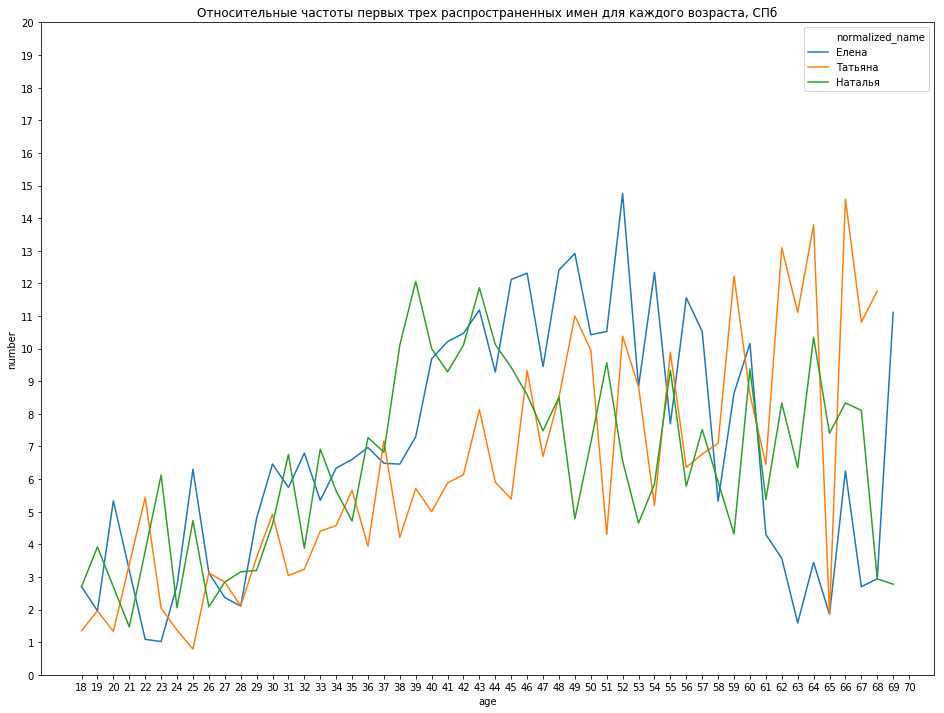

In [30]:
names_age = []
dict_vc = dict(spbf['selfAge'].value_counts())
top_names = ['Елена', 'Наталья', 'Татьяна']
for k, v in spbf.groupby(['selfAge','normalized_name']).groups.items():
    if k[0] > 0 and k[0] <= 70 and k[1] in top_names:
        names_age.append({'age': k[0], 'normalized_name': k[1], 'number': 100*len(v)/ dict_vc[k[0]]})
df_names_age = pd.DataFrame(names_age)
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.lineplot(x='age', y='number', data=df_names_age, hue='normalized_name')
ax.set_title('Относительные частоты первых трех распространенных имен для каждого возраста, СПб')
ax.set_xticks(np.arange(18, 71, 1));
ax.set_yticks(np.arange(0, 21, 1));

В СПб частоты всех трех самых популярных имен в общем растут примерно до 43 лет. После этого они ведут себя по-разному.

Частота имени "Елена" продолжает расти до 52 года, достигая максимума в 15%, после чего снижается с колебаниями, достигая минимума в 63 года (2%).

Частота имени "Татьяна", несмотря на колебания, устойчиво растет. При этом в 65 лет видим резкое падение до 2%.

Частота имени "Наталья" достигает максимума в 39 лет (12%), после чего постепенно падает.

Сравнивая данные по двум городам, можно констатировать, что все имена из топ-3 были в роли лидера в определенные годы. Сильный всплеск частоты имени "Елена" (19%) в Москве в районе 55 лет имеет более скромное соответствие в СПб (15%, 52 года).

<h3>4. Желаемый возраст партнера</h3>

В анкетах желаемый возраст партнера (точнее, человека, с которым желают познакомиться - далее ради краткости он везде именуется партнером) является диапазоном. Диапазон на сайте выбирается не произвольно, а из небольшого числа вариантов.

In [31]:
# фильтруем анкеты по наличию возраста партнера
mf_age = mf[mf['partnerAge']!=""]
mf_age = mf_age.reset_index(drop=True)
spbf_age = spbf[spbf['partnerAge']!=""]
spbf_age = spbf_age.reset_index(drop=True)

In [32]:
print("Доля указанного желаемого возраста партнера, Москва: {0:2.1f}%".format(100 * len(mf_age) / len(mf)))

Доля указанного желаемого возраста партнера, Москва: 97.4%


In [33]:
print("Доля указанного желаемого возраста партнера, СПб: {0:2.1f}%".format(100 * len(spbf_age) / len(spbf)))

Доля указанного желаемого возраста партнера, СПб: 97.7%


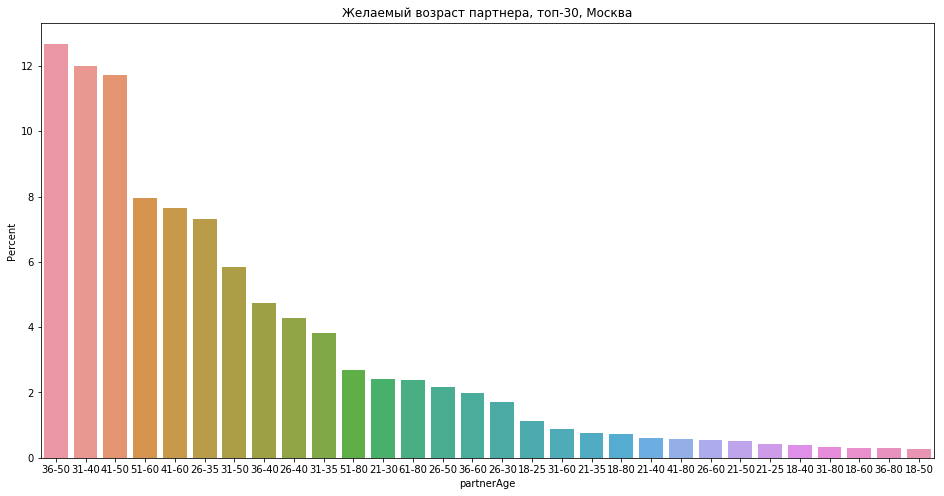

In [34]:
show_percent_ordered(mf_age, 'partnerAge', 'Желаемый возраст партнера, топ-30, Москва', limit=30)

В Москве наиболее популярны возрасты, в сумме представляющие более трети анкет - это 36-50, 31-40 и 41-50.

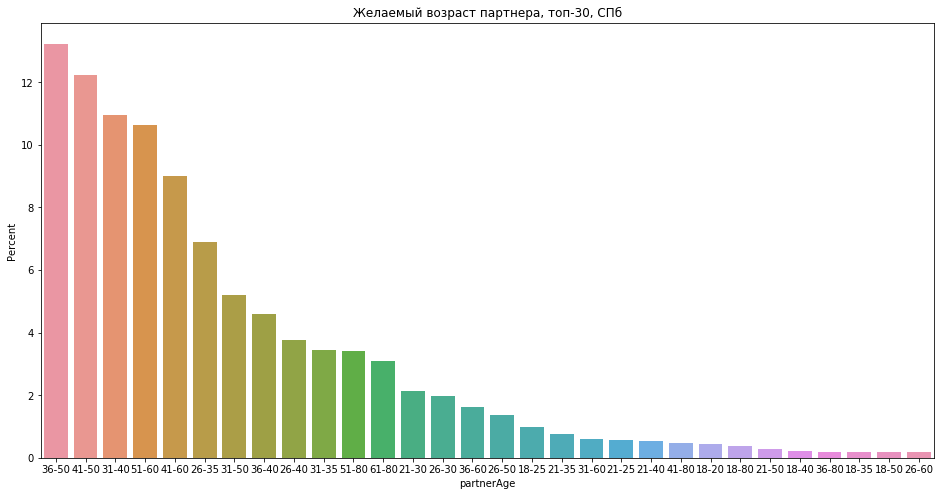

In [35]:
show_percent_ordered(spbf_age, 'partnerAge', 'Желаемый возраст партнера, топ-30, СПб', limit=30)

В СПб первая тройка желаемых возрастов такая же, как и в Москве. Первое место опять же у диапазона 36-50, а второе и третье места обратны московским. Однако первая тройка не имеет такого большого отрыва от прочих диапазонов, как в Москве.

Определим медианную верхнюю границу и медианную нижнюю границу диапазонов желаемого возраста партнера для каждого возраста. На их основе посчитаем желаемый медианный возраст партнера.

In [36]:
mf_age['partnerAge_min'] = mf_age['partnerAge_min'].astype(float)
mf_age['partnerAge_max'] = mf_age['partnerAge_max'].astype(float)
mf_age['partnerAge_avg'] = mf_age['partnerAge_avg'].astype(float)

spbf_age['partnerAge_min'] = spbf_age['partnerAge_min'].astype(float)
spbf_age['partnerAge_max'] = spbf_age['partnerAge_max'].astype(float)
spbf_age['partnerAge_avg'] = spbf_age['partnerAge_avg'].astype(float)

m_partnerAge_mins = mf_age.groupby(['selfAge',])['partnerAge_min'].median()
m_partnerAge_maxs = mf_age.groupby(['selfAge',])['partnerAge_max'].median()
m_partnerAge_avg = mf_age.groupby(['selfAge',])['partnerAge_avg'].median()

spbf_partnerAge_mins = spbf_age.groupby(['selfAge',])['partnerAge_min'].median()
spbf_partnerAge_maxs = spbf_age.groupby(['selfAge',])['partnerAge_max'].median()
spbf_partnerAge_avg = spbf_age.groupby(['selfAge',])['partnerAge_avg'].median()

In [37]:
def show_partner_age_by_age(partnerAge_mins, partnerAge_maxs, partnerAge_avg, param, title):
    '''
        Показать медианные параметры желаемого возраста партнера согласно возрасту анкеты
    '''

    dff = []

    partner_ages = (partnerAge_mins, partnerAge_maxs, partnerAge_avg)
    partner_age_label = ('min', 'max', 'avg')

    for i, pa in enumerate(partner_ages):
        for age, pa_i in zip(range(18, 81), pa):    

            dff.append(
                {'age': age,
                 'partner_age': pa_i,
                 'label': partner_age_label[i],
                 'diff': pa_i - age
                }
            )
    df = pd.DataFrame(dff)
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.lineplot(x='age', y=param, data=df, hue='label')
    ax.set_title(title)
    ax.set_xticks(np.arange(18, 80, 2)) 
    ax.set_yticks(np.arange(0, 100, 5)) 
    

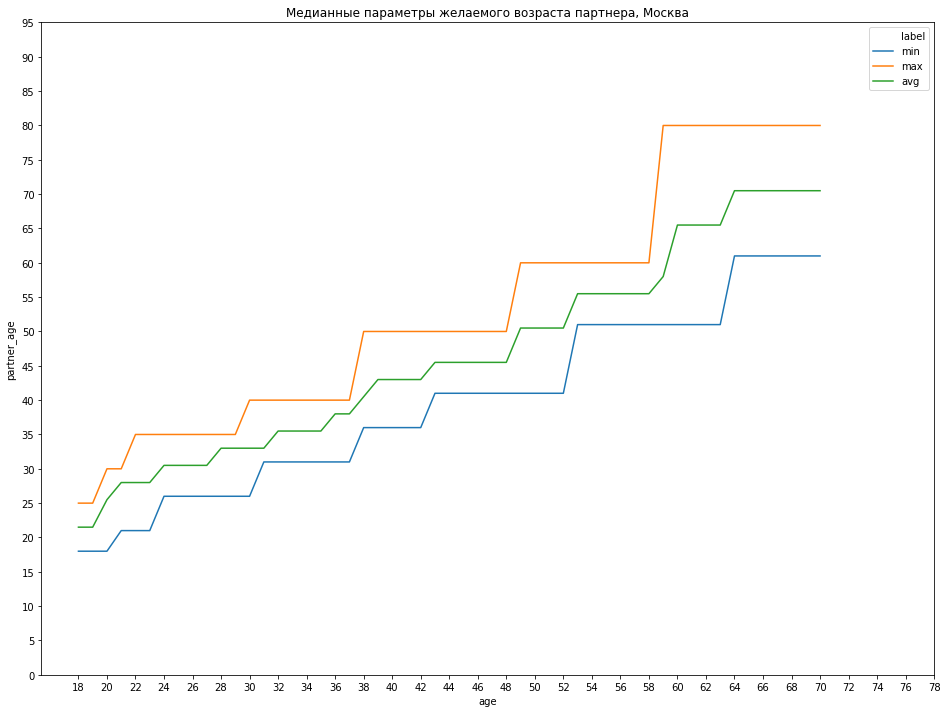

In [38]:
show_partner_age_by_age(m_partnerAge_mins, m_partnerAge_maxs, m_partnerAge_avg, 'partner_age', 
                        'Медианные параметры желаемого возраста партнера, Москва')

Итак, желаемый возраст партнера повышается по мере повышения возраста владельца анкеты. Для наглядности рассмотрим  разницу между возрастом владелицы анкеты и желаемым возрастом партнера.

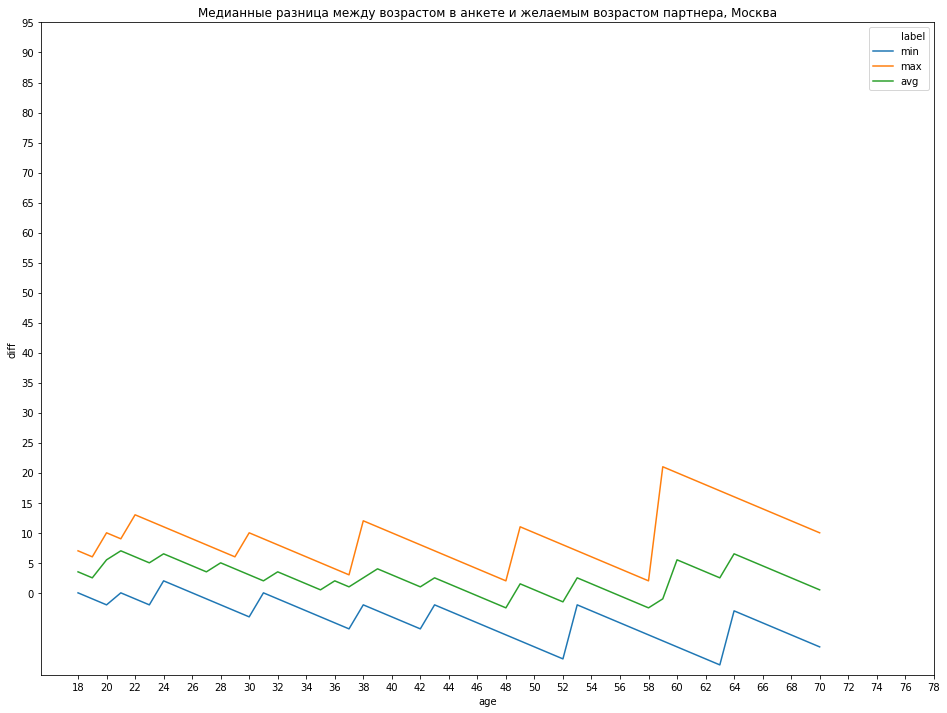

In [39]:
show_partner_age_by_age(m_partnerAge_mins, m_partnerAge_maxs, m_partnerAge_avg, 'diff', 
                        'Медианные разница между возрастом в анкете и желаемым возрастом партнера, Москва')

Мы видим, что в Москве медианный желаемый возраст до 49 лет всегда выше, чем возраст, указанный в анкете. После 49 лет он колеблется возле нуля, и размах его границ устойчиво растет.

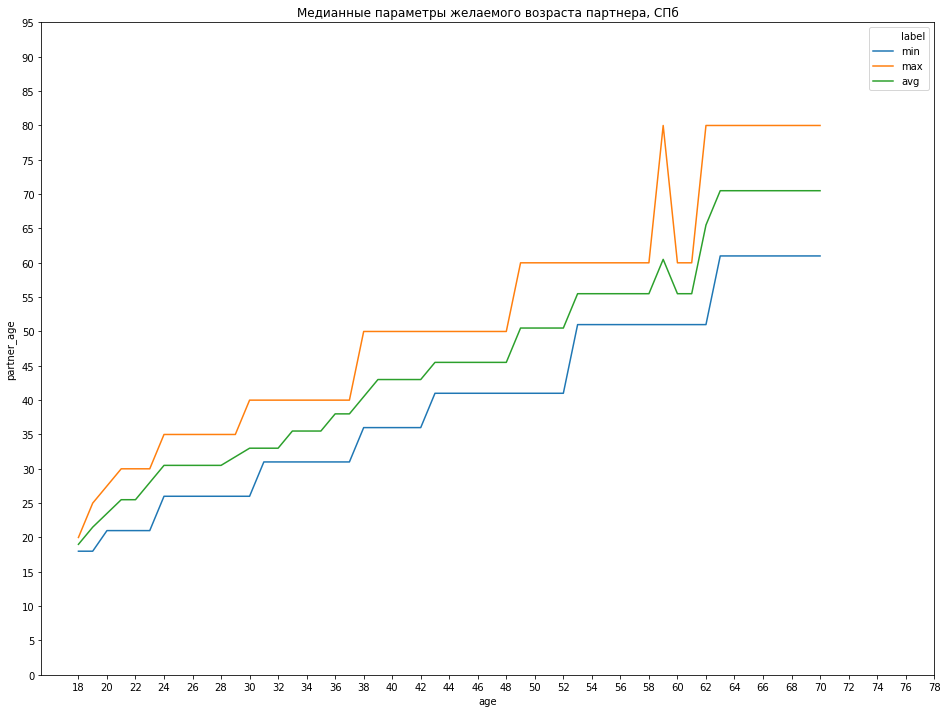

In [40]:
show_partner_age_by_age(spbf_partnerAge_mins, spbf_partnerAge_maxs, spbf_partnerAge_avg, 'partner_age',
                       'Медианные параметры желаемого возраста партнера, СПб')

Как и в Москве, в СПб желаемый возраст партнера повышается по мере повышения возраста владелицы анкеты.

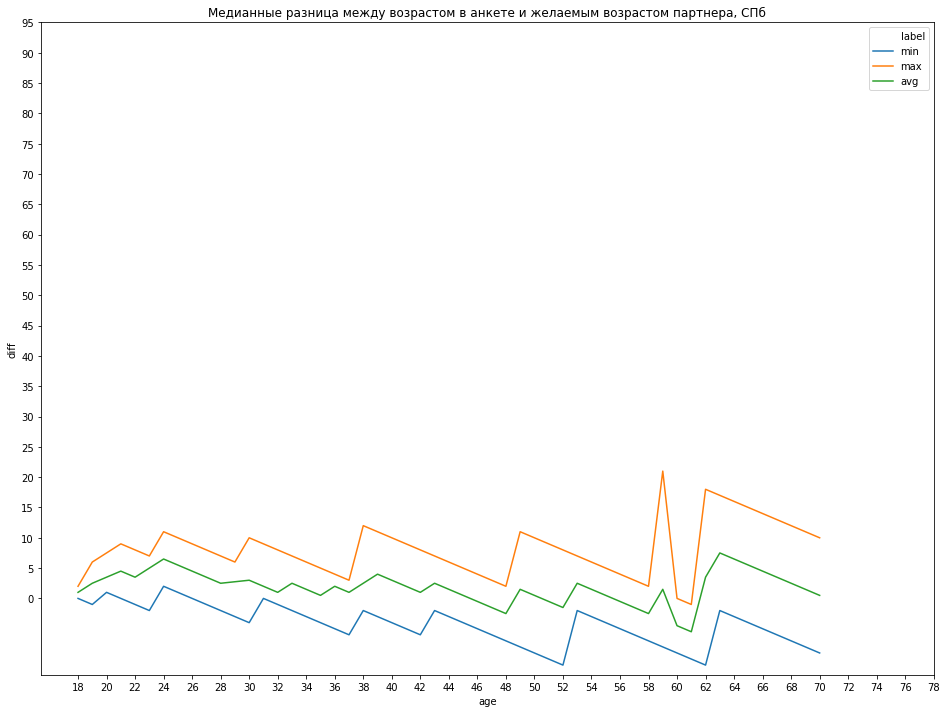

In [41]:
show_partner_age_by_age(spbf_partnerAge_mins, spbf_partnerAge_maxs, spbf_partnerAge_avg, 'diff',
                       'Медианные разница между возрастом в анкете и желаемым возрастом партнера, СПб')

В отличие от Москвы, медианный желаемый возраст выше возраста, указанного в анкете, примерно до 47 лет. После этого возраста, как и в Москве, он колеблется возле нуля. Размах границ желаемого возраста, как и в Москве, с возрастом устойчиво растет.

<h3>5. Пол партнера</h3>

In [42]:
def show_pie_chart(df, col, title, limit=0):
    '''
        Показать круговую гистограмму
    '''
    
    f, ax = plt.subplots(figsize=(8, 8))
    if limit == 0:
        df[col].value_counts().plot(kind='pie', subplots=True, autopct='%.2f', title=title)
    else:
        df[col].value_counts()[:limit].plot(kind='pie', subplots=True, autopct='%.2f', title=title)

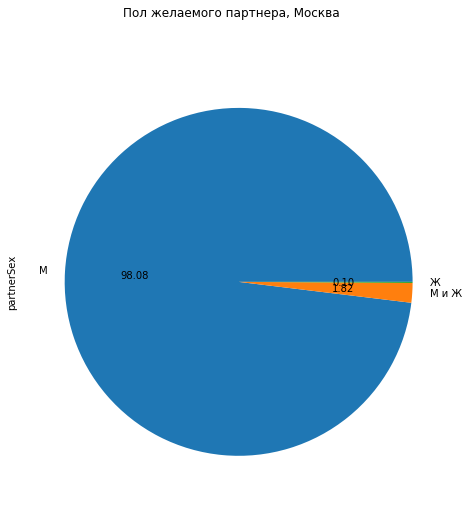

In [43]:
show_pie_chart(mf, 'partnerSex', 'Пол желаемого партнера, Москва')

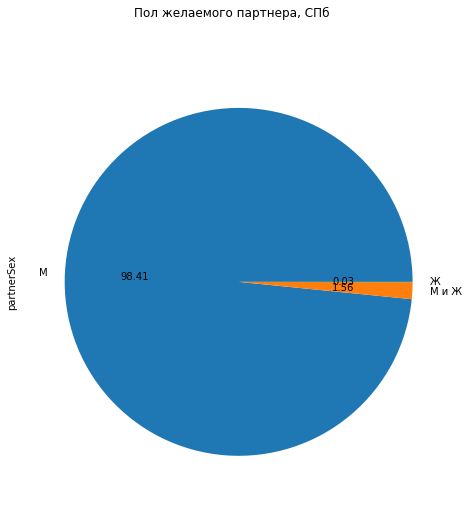

In [44]:
show_pie_chart(spbf, 'partnerSex', 'Пол желаемого партнера, СПб')

Итак, в обоих городах подавляющее большинство (~98%) желает найти человека исключительно противоположного пола.

<h3>6. Вес</h3>

In [45]:
def drop_na(df, field):
    df = df.dropna(subset=[field])
    return df.reset_index(drop=True)

mf_weight = drop_na(mf, 'weight')
spbf_weight = drop_na(spbf, 'weight')

In [46]:
print("Процент анкет с указанным весом в Москве: {0:2.2f}".format(100 * len(mf_weight) / 10000))

Процент анкет с указанным весом в Москве: 49.79


In [47]:
print("Процент анкет с указанным весом в СПб: {0:2.2f}".format(100 * len(spbf_weight) / 10000))

Процент анкет с указанным весом в СПб: 47.72


In [48]:
mf_weight['weight_kg'] = mf_weight['weight'].apply(lambda x: int(x.split(' ')[0]))

In [49]:
print("Медианный вес в Москве, кг: {0:2.1f}".format(mf_weight['weight_kg'].median()))

Медианный вес в Москве, кг: 60.0


In [50]:
print("Средний вес в Москве, кг: {0:2.1f}".format(mf_weight['weight_kg'].mean()))

Средний вес в Москве, кг: 62.1


In [51]:
print("Стандартное отклонение веса в Москве: {0:2.1f}".format(mf_weight['weight_kg'].std()))

Стандартное отклонение веса в Москве: 12.5


/home/hrutr/.virtualenvs/dating/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


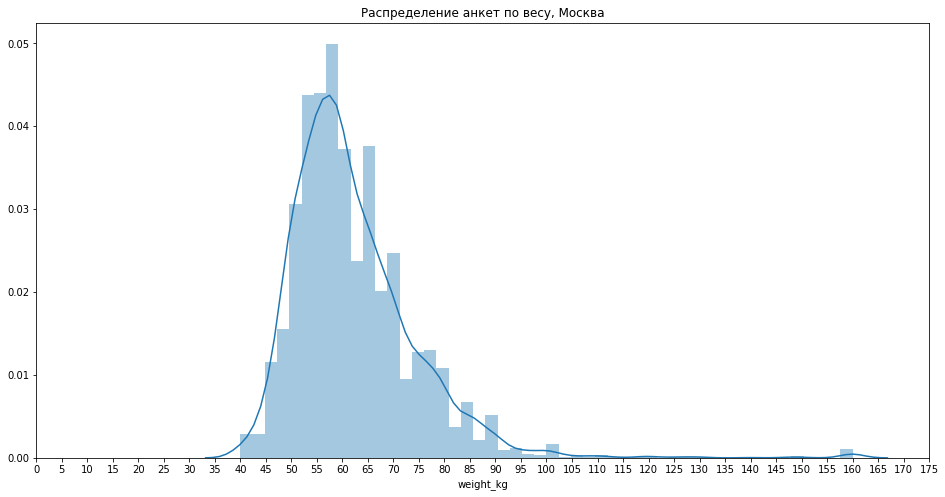

In [52]:
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(mf_weight['weight_kg'], kde=True, rug=False)
ax.set_title('Распределение анкет по весу, Москва')
ax.set_xticks(np.arange(0, 180, 5));

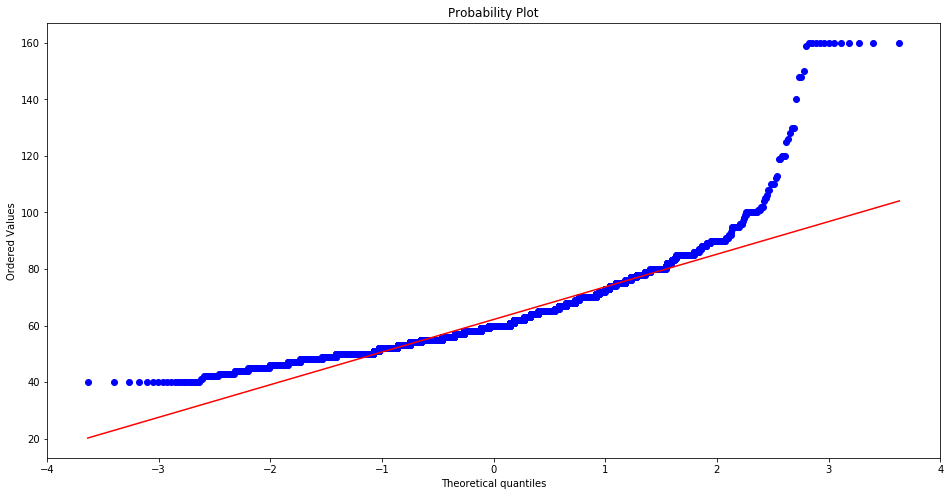

In [53]:
# qq-plot, вес, Москва
f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(mf_weight['weight_kg'], plot=plt)
plt.show()

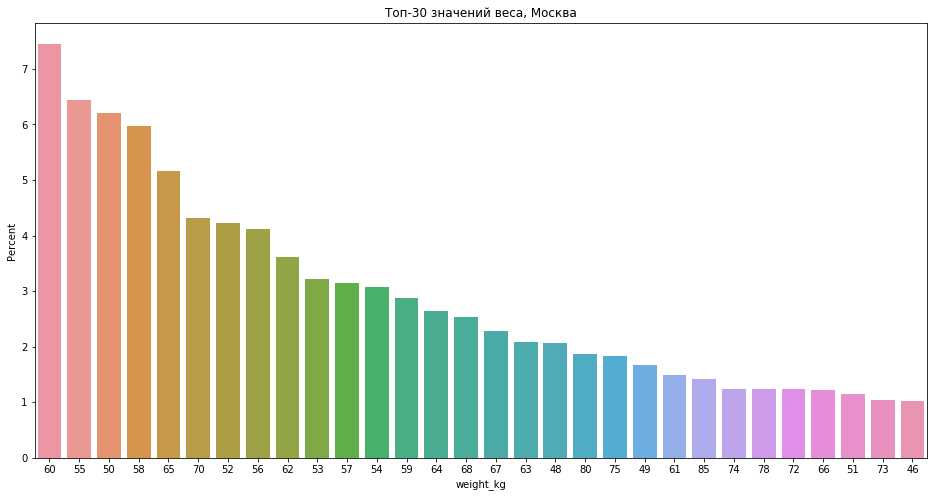

In [54]:
show_percent_ordered(mf_weight, 'weight_kg', 'Топ-30 значений веса, Москва', limit=30)

In [55]:
spbf_weight['weight_kg'] = spbf_weight['weight'].apply(lambda x: int(x.split(' ')[0]))

In [56]:
print("Медианный вес в СПб, кг: {0:2.1f}".format(spbf_weight['weight_kg'].median()))

Медианный вес в СПб, кг: 60.0


In [57]:
print("Средний вес в СПб, кг: {0:2.1f}".format(spbf_weight['weight_kg'].mean()))

Средний вес в СПб, кг: 62.3


In [58]:
print("Стандартное отклонение веса в СПб: {0:2.1f}".format(spbf_weight['weight_kg'].std()))

Стандартное отклонение веса в СПб: 12.5


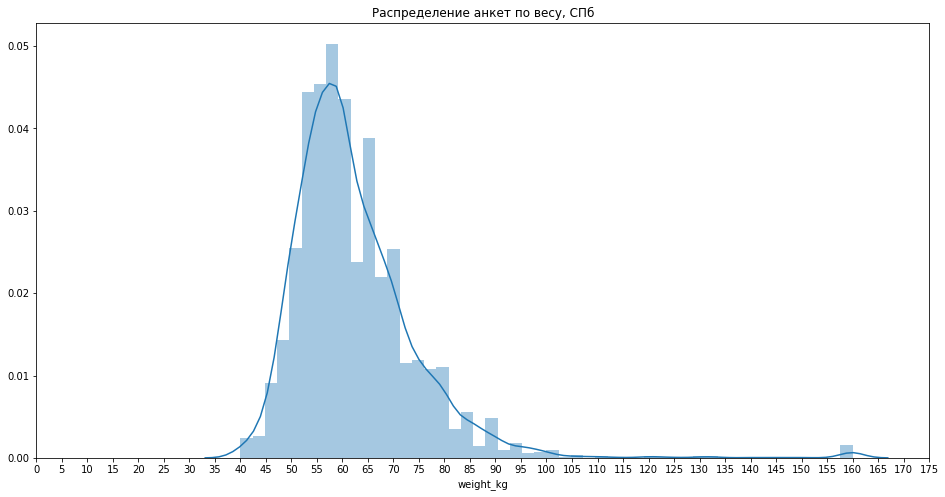

In [59]:
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(spbf_weight['weight_kg'], kde=True, rug=False)
ax.set_title('Распределение анкет по весу, СПб')
ax.set_xticks(np.arange(0, 180, 5));

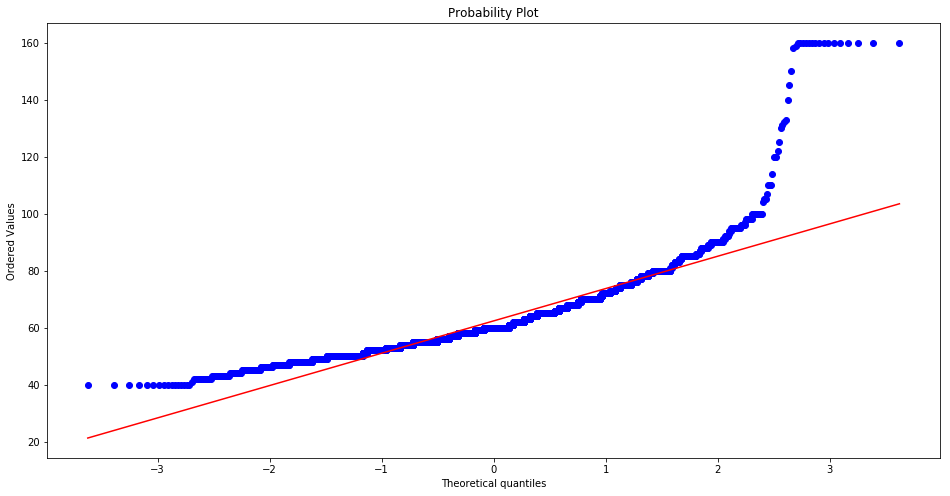

In [60]:
# qq-plot, вес, СПб
f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(spbf_weight['weight_kg'], plot=plt)
plt.show()

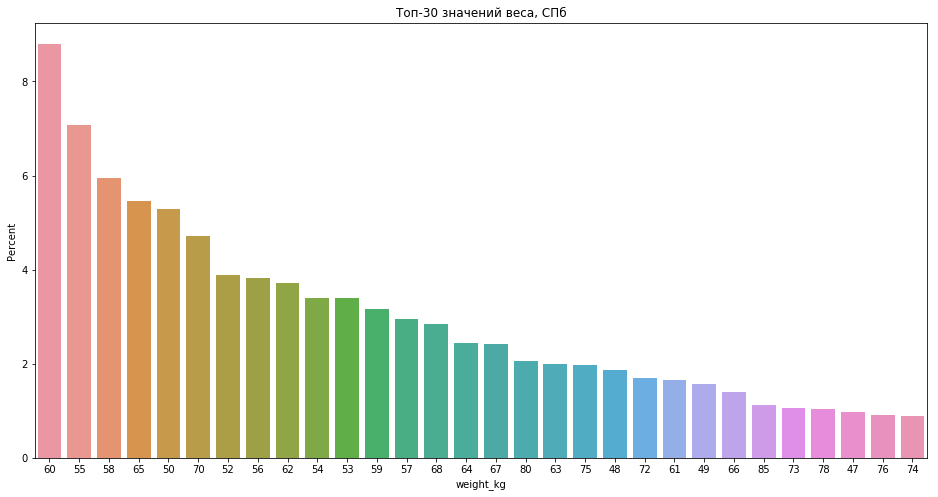

In [61]:
# гистограмма первых 30 значений веса по частоте, СПб
show_percent_ordered(spbf_weight, 'weight_kg', 'Топ-30 значений веса, СПб', limit=30)

Если построить график распределения веса от возраста, увидим следующее.

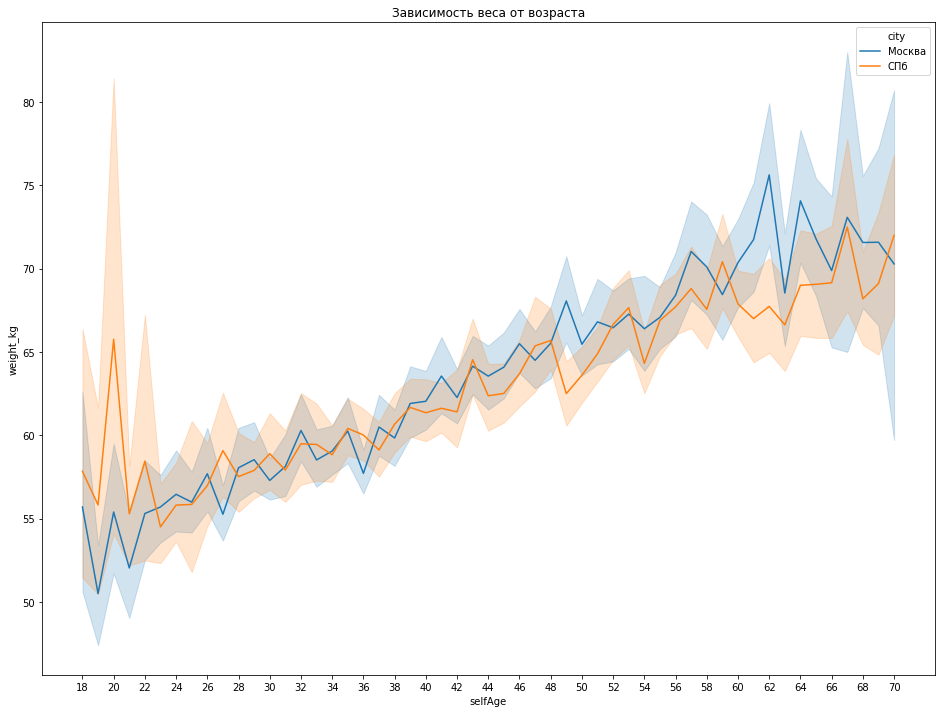

In [62]:
mf_weight['city'] = 'Москва'
spbf_weight['city'] = 'СПб'
weight = pd.concat([mf_weight, spbf_weight], sort=False)
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.lineplot(x='selfAge', y='weight_kg', data=weight, hue='city')
ax.set_title('Зависимость веса от возраста')
ax.set_xticks(np.arange(18, 71, 2));

В Москве средний вес устойчиво растет до 64 лет, после чего начинает колебаться. В СПб, в отличие от Москвы, средний вес резко колеблется до 23 лет (пик в 21 год, 66 кг), после чего устойчиво растет. Видно, что средний вес в СПб выше московского до 24 лет и часто ниже после 40 лет.

<h3>7. Рост</h3>

In [63]:
mf_height = drop_na(mf, 'height')
print("Процент анкет с указанным ростом, Москва: {0:2.1f}".format(100 * len(mf_height)/10000))

Процент анкет с указанным ростом, Москва: 72.1


In [64]:
spbf_height = drop_na(spbf, 'height')
print("Процент анкет с указанным ростом, СПб: {0:2.1f}".format(100 * len(spbf_height)/10000))

Процент анкет с указанным ростом, СПб: 73.7


In [65]:
mf_height['height_cm'] = mf_height['height'].apply(lambda x: int(x.split(' ')[0]))

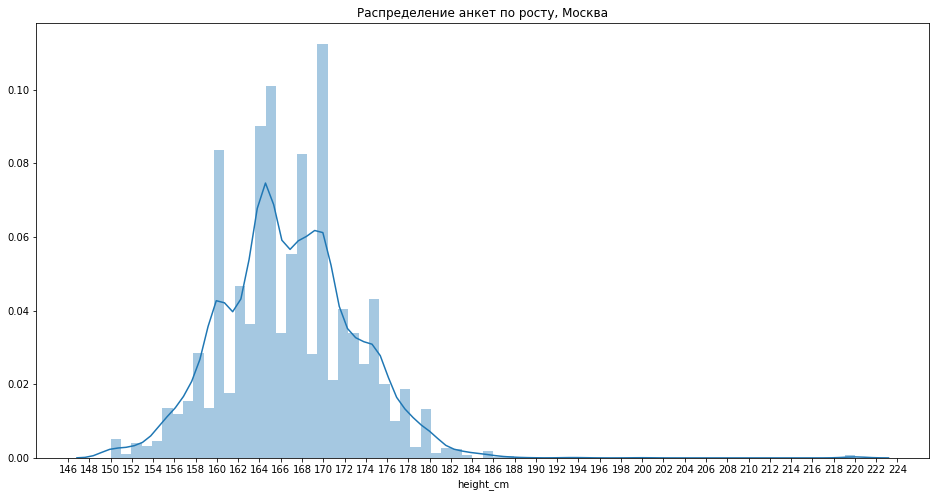

In [66]:
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(mf_height['height_cm'], kde=True, rug=False, bins=223-151)
ax.set_title('Распределение анкет по росту, Москва')
ax.set_xticks(np.arange(146, 226, 2));

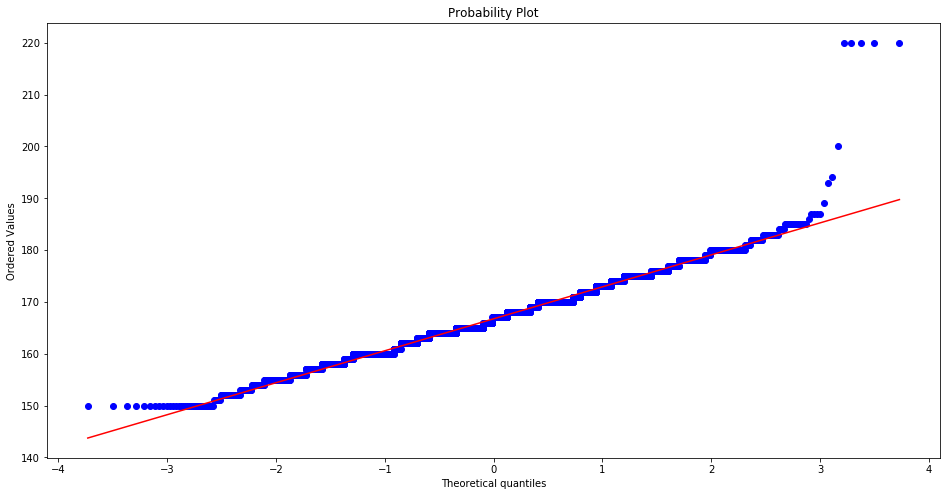

In [67]:
# qq-plot, рост, Москва
f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(mf_height['height_cm'], plot=plt)
plt.show()

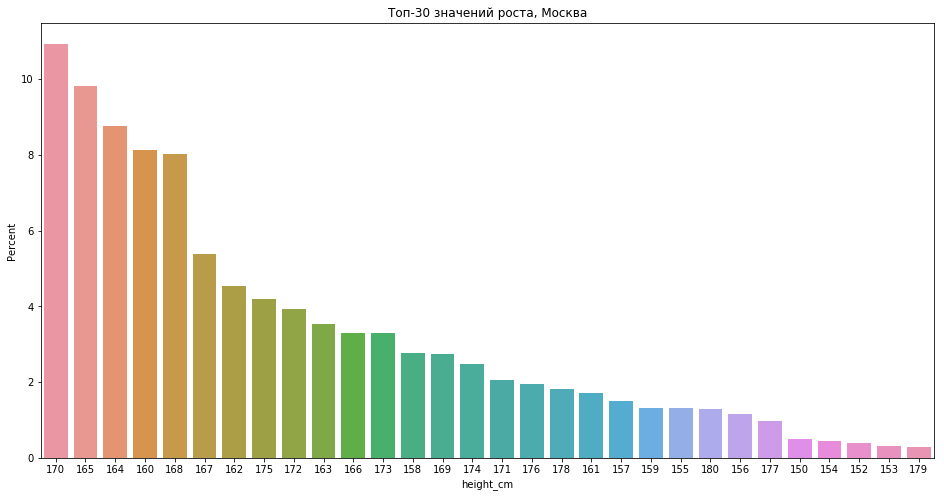

In [68]:
show_percent_ordered(mf_height, 'height_cm', 'Топ-30 значений роста, Москва', limit=30)

In [69]:
print("Медианный рост в Москве, см: {0:2.1f}".format(mf_height['height_cm'].median()))

Медианный рост в Москве, см: 167.0


In [70]:
print("Средний рост в Москве, см: {0:2.1f}".format(mf_height['height_cm'].mean()))

Средний рост в Москве, см: 166.7


In [71]:
print("Стандартное отклонение роста в Москве: {0:2.1f}".format(mf_height['height_cm'].std()))

Стандартное отклонение роста в Москве: 6.2


In [72]:
spbf_height['height_cm'] = spbf_height['height'].apply(lambda x: int(x.split(' ')[0]))

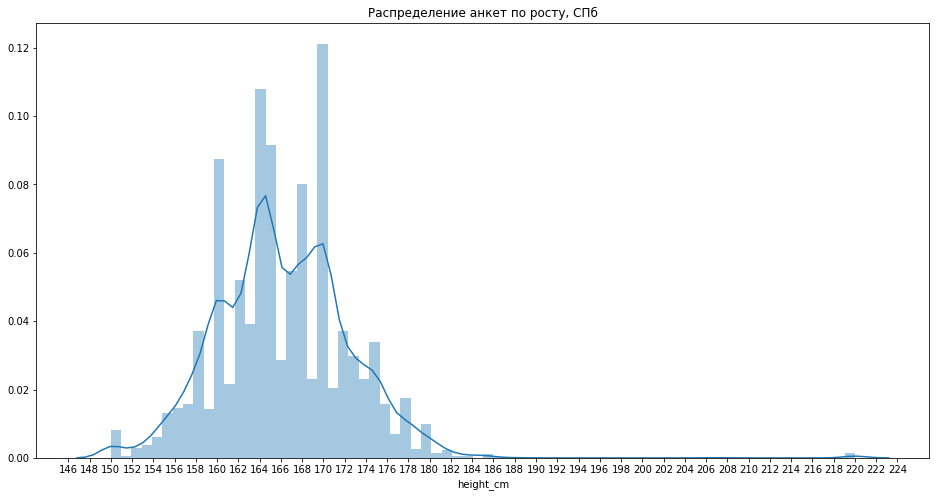

In [73]:
f, ax = plt.subplots(figsize=(16, 8))
sns.distplot(spbf_height['height_cm'], kde=True, rug=False, bins=223-151)
ax.set_title('Распределение анкет по росту, СПб')
ax.set_xticks(np.arange(146, 226, 2));

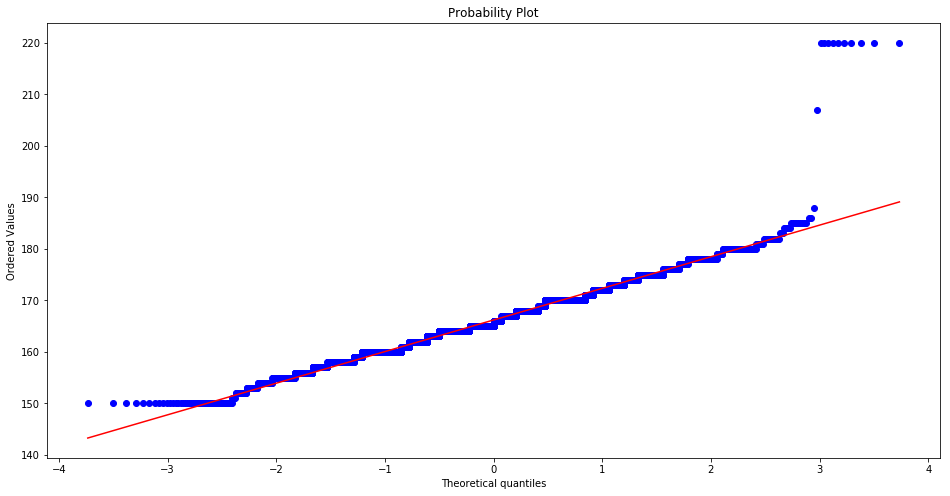

In [74]:
# qq plot, рост, СПб
f, ax = plt.subplots(figsize=(16, 8))
res = stats.probplot(spbf_height['height_cm'], plot=plt)
plt.show()

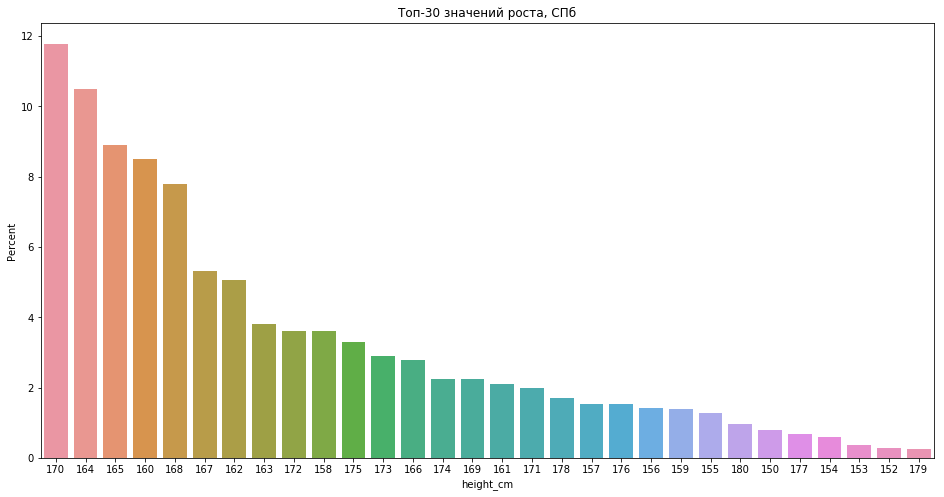

In [75]:
show_percent_ordered(spbf_height, 'height_cm', 'Топ-30 значений роста, СПб', limit=30)

In [76]:
print("Медианный рост в СПб, см: {0:2.1f}".format(spbf_height['height_cm'].median()))

Медианный рост в СПб, см: 165.0


In [77]:
print("Средний рост в СПб, см: {0:2.1f}".format(spbf_height['height_cm'].mean()))

Средний рост в СПб, см: 166.2


In [78]:
print("Стандартное отклонение роста в СПб: {0:2.1f}".format(spbf_height['height_cm'].std()))

Стандартное отклонение роста в СПб: 6.3


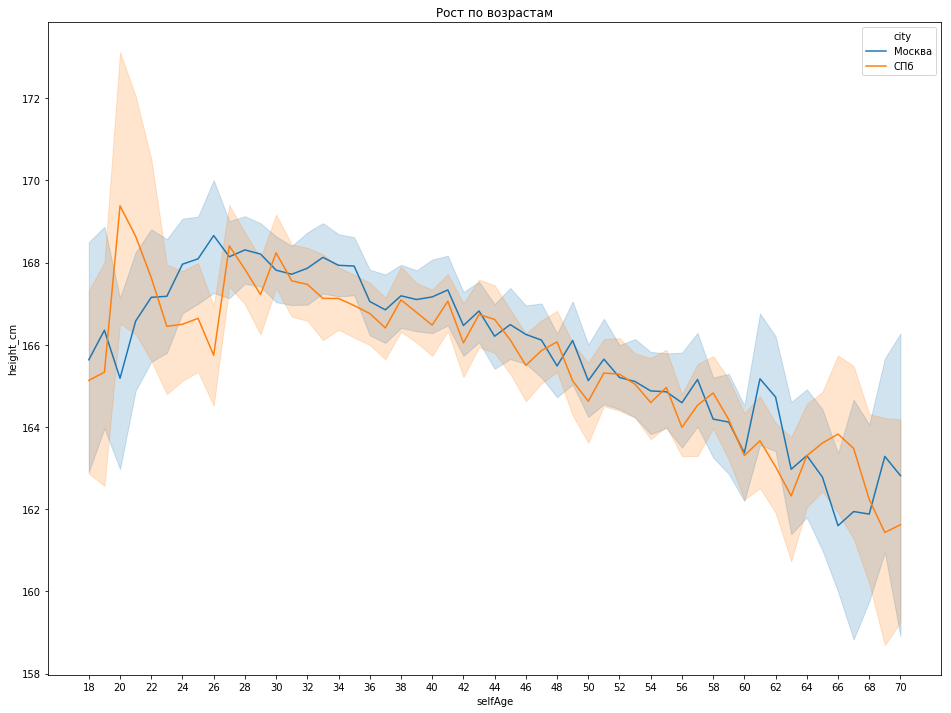

In [79]:
mf_height['city'] = 'Москва'
spbf_height['city'] = 'СПб'
height = pd.concat([mf_height, spbf_height], sort=False)
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.lineplot(x='selfAge', y='height_cm', data=height, hue='city')
ax.set_title('Рост по возрастам')
ax.set_xticks(np.arange(18, 71, 2));

В Москве рост до 22 лет колеблется, после чего устойчиво растет до 29 лет. После этого возраста он устойчиво снижается. В 60-62 года отмечен всплеск, после которого падение продолжается. В СПб примерно до 29 лет средний рост колеблется в значительных пределах, после чего устойчиво падает. Видно, что почти во всех возрастах средний рост в СПб несколько ниже московского.

Полученные результаты можно сравнить с результатами <a href="https://iz.ru/news/600878">исследования 2015 г.</a>, согласно которым средний рост женщин в Москве и СПб одинаков и составляет 166 см для женщин от 18 до 30 лет.

In [80]:
print("Средний рост женщин от 18 до 30 лет, Москва: {0:.2f} см".format(mf_height[mf_height.selfAge<=30]['height_cm'].mean()))

Средний рост женщин от 18 до 30 лет, Москва: 167.85 см


In [81]:
print("Средний рост женщин от 18 до 30 лет, СПб: {0:.2f} см".format(spbf_height[spbf_height.selfAge<=30]['height_cm'].mean()))

Средний рост женщин от 18 до 30 лет, СПб: 167.41 см


Итак, что согласно данным анкет на mheart.ru средний рост женщин от 18 до 30 лет в обоих городах примерно одинаков, но на примерно полтора сантиметра выше, чем в исследовании 2015 г.

<h3>8. Телосложение</h3>

In [82]:
mf['build'] = mf['build'].fillna('Не указано')
spbf['build'] = spbf['build'].fillna('Не указано')

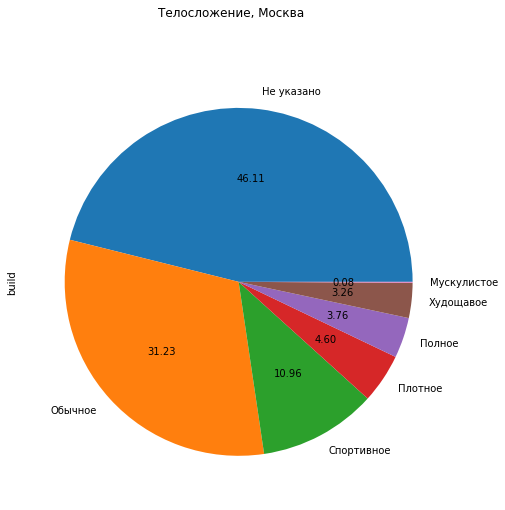

In [83]:
show_pie_chart(mf, 'build', 'Телосложение, Москва')

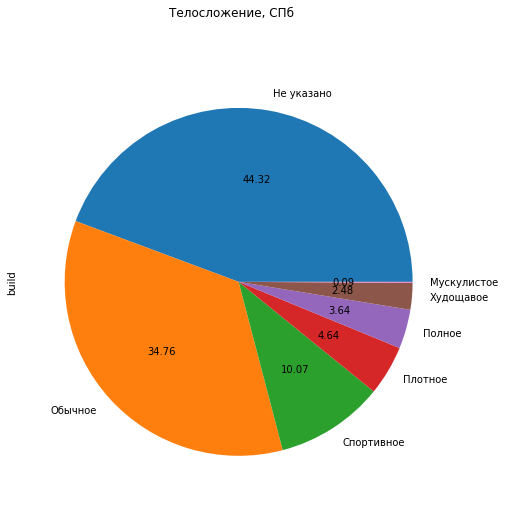

In [84]:
show_pie_chart(spbf, 'build', 'Телосложение, СПб')

Распределение по долям в Москве и в СПб практически одинаковое, единственное заметное отличие - в СПб доля неуказанного телосложения на несколько процентов ниже, а доля обычного - на несколько процентов выше.

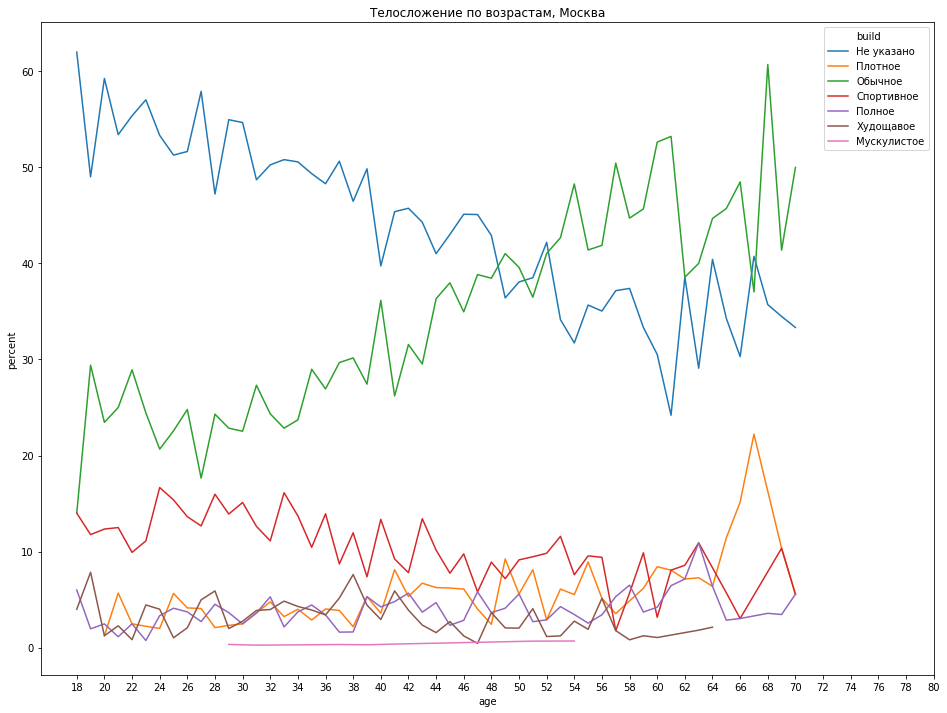

In [85]:
show_params_by_age(mf, 'build', 'Телосложение по возрастам, Москва')

Доля не указавших свое телосложение в Москве со временем снижается более чем вдвое. Одновременно растет доля обычного телосложения. Доля спортивного телосложения не превышает 15% ни в каком возрасте и со временем снижается. Полное, плотное и худощавое конкурируют между собой, находясь в меньшинстве. Мускулистое телосложение отмечается   только на отрезке от 29 до 55 лет, его доля чуть выше нуля.

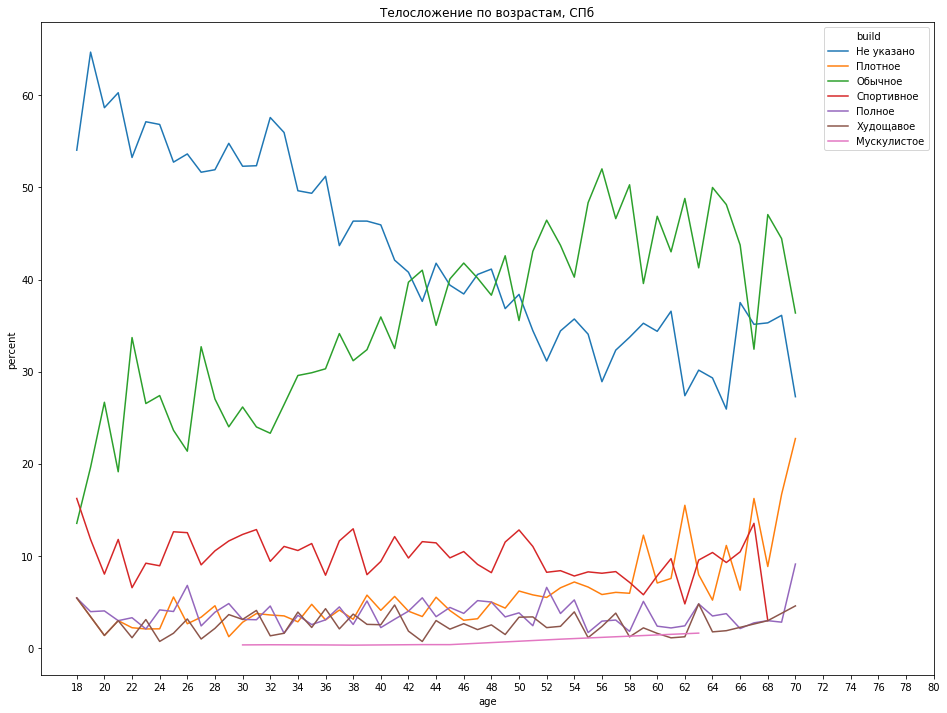

In [86]:
show_params_by_age(spbf, 'build', 'Телосложение по возрастам, СПб')

Доля не указавших свое телосложение в СПб, как и в Москве, со временем снижается более чем вдвое, и точно так же  растет доля обычного телосложения. Доля спортивного телосложения, хотя и не превышает 15%, снижается со временем очень медленно. Полное, плотное и худощавое, как и в Москве, конкурируют между собой, находясь в меньшинстве. Мускулистое телосложение отмечается только на отрезке от 30 до 63 лет (этот диапазон длиннее, чем в Москве), его доля чуть выше нуля, но со временем несколько растет.

<h3>9. Владение языками</h3>

Во многих анкетах поле "Знание языков" оставлено пустым. В таком случае будем считать, что автор знает только русский язык.

In [87]:
def normalize_languages(x):
    if x is not None:
        if x == 'nan' or x == 'None':
            return 'Русский'
        x_list = x.split(',')
        x_list_filtered = [x for x in x_list if x!='Русский (Russian)']
        if x_list_filtered:
            res = ', '.join(x_list_filtered)
            return res
        else:
            return 'Русский'
    return 'Русский'

In [88]:
mf['languages'] = mf['languages'].astype(str)
mf['languages_normalized'] = mf['languages'].apply(normalize_languages)
spbf['languages'] = spbf['languages'].astype(str)
spbf['languages_normalized'] = spbf['languages'].apply(normalize_languages)

Посмотрим на знание языков в московских и питерских анкетах (показаны первые по частоте 5 вариантов ответа).

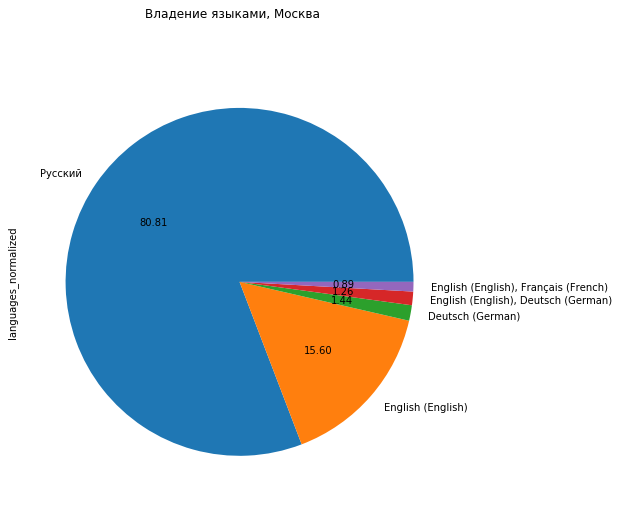

In [89]:
show_pie_chart(mf, 'languages_normalized', 'Владение языками, Москва', limit=5)

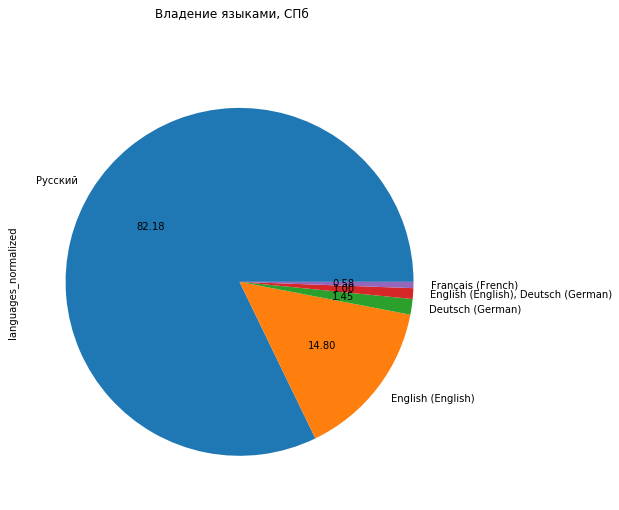

In [90]:
show_pie_chart(spbf, 'languages_normalized', 'Владение языками, СПб', limit=5)

Итак, примерно 81% москвичек не указали ни одного языка, меньше 16% владеют одним английским, менее 2% - одним немецким. Прочие варианты имеют крайне малую частоту. Культурная столица в общем следует московскому распределению частот. Ситуация в общем даже хуже: в первую пятерку вошла только одна пара языков в отличие от двух в Москве.

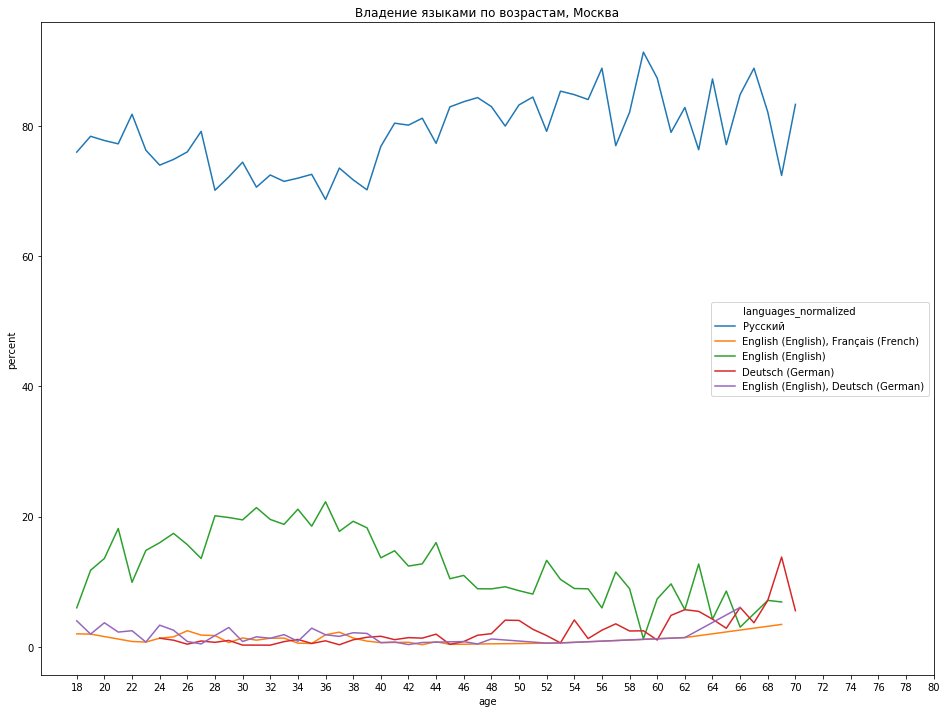

In [91]:
show_params_by_age(mf, 'languages_normalized', 'Владение языками по возрастам, Москва', limit=5)

В Москве доля анкет с одним русским языком колеблется возле отметки в 80%, спускаясь до минимальных значений в диапазоне от 30 до 40 лет. В этом же диапазоне повышается доля владения английским, стабильно падая после 37. Владение одним немецким встречается стабильно редко до 46 лет, но растет в последующие годы.

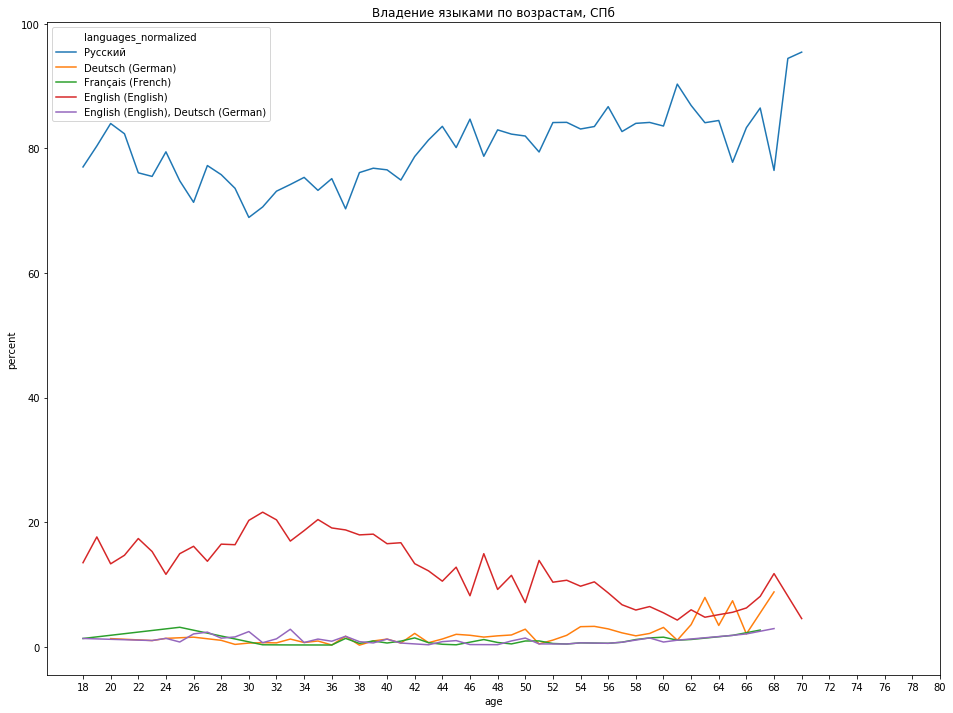

In [92]:
show_params_by_age(spbf, 'languages_normalized', 'Владение языками по возрастам, СПб', limit=5)

Как видно, в СПб распределение знания языков по возрасту очень похоже на московское, только пару французский-английский здесь заменяет французский. 

<h3>10. Образование</h3>

Оценим распределение уровня образования в Москве и СПб.

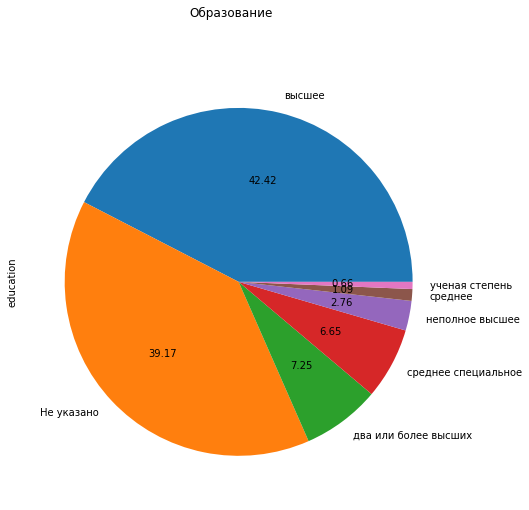

In [93]:
mf['education'] = mf['education'].fillna('Не указано')
show_pie_chart(mf, 'education', 'Образование')

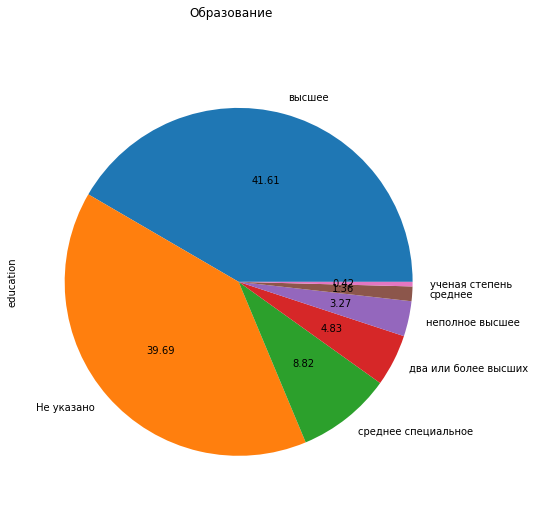

In [94]:
spbf['education'] = spbf['education'].fillna('Не указано')
show_pie_chart(spbf, 'education', 'Образование')

В СПб два лидера тождественны московским - это "не указано" и "высшее образование", с похожими процентами. Но на третьем месте не два или более высших, а среднее специальное. В СПб ниже доля ученых степеней, но выше - неполного высшего. Можно сделать вывод, что в общем уровень образования в петербургских анкетах несколько ниже московского.

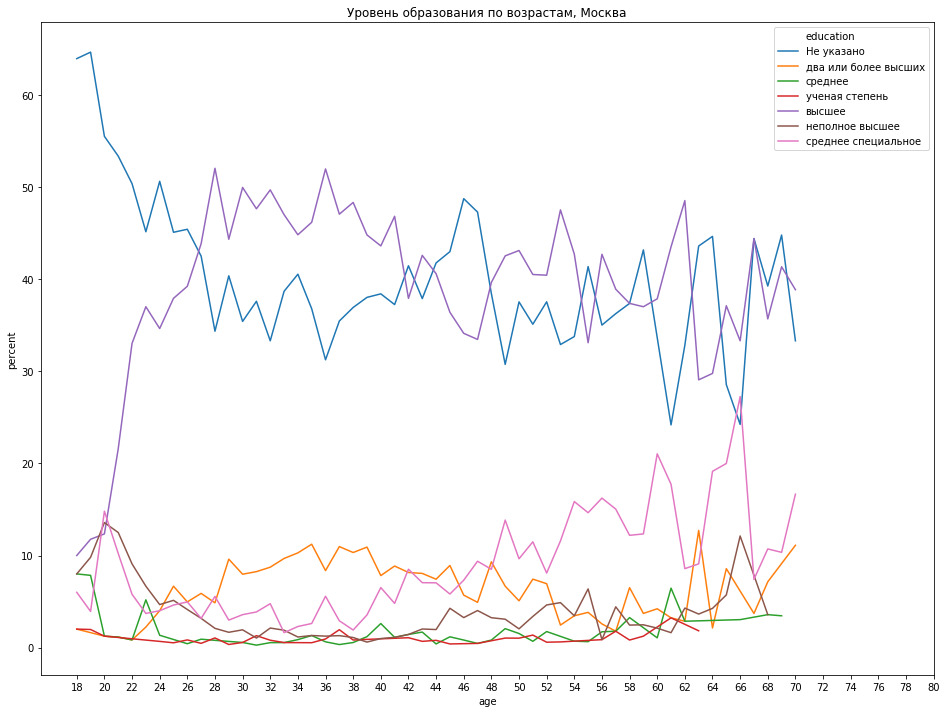

In [95]:
show_params_by_age(mf, 'education', 'Уровень образования по возрастам, Москва')

Мы видим, что доля не указывающих образование с довольно высоких значений быстро снижается, достигая минимума в 38 лет, после чего вновь возрастает до 48 лет. Далее наблюдаются резкие колебания.

Доля высшего образования очень быстро растет, достигая максимума в 29 лет, после чего колеблется, постепенно снижаясь. Неполное высшее растет до 22 лет, а затем быстро падает примерно до 42 лет, где постепенно начинает повышаться. Доля двух и более высших растет с 22 лет, доходя до максимума в 36, после чего снижается. Доля среднего специального быстро растет к 20 годам, поле чего снижается, но начиная с 28 постепенно растет, выходя в 68 лет на сторое место. Доли среднего образования и ученой степени стабильно близки к нулю.

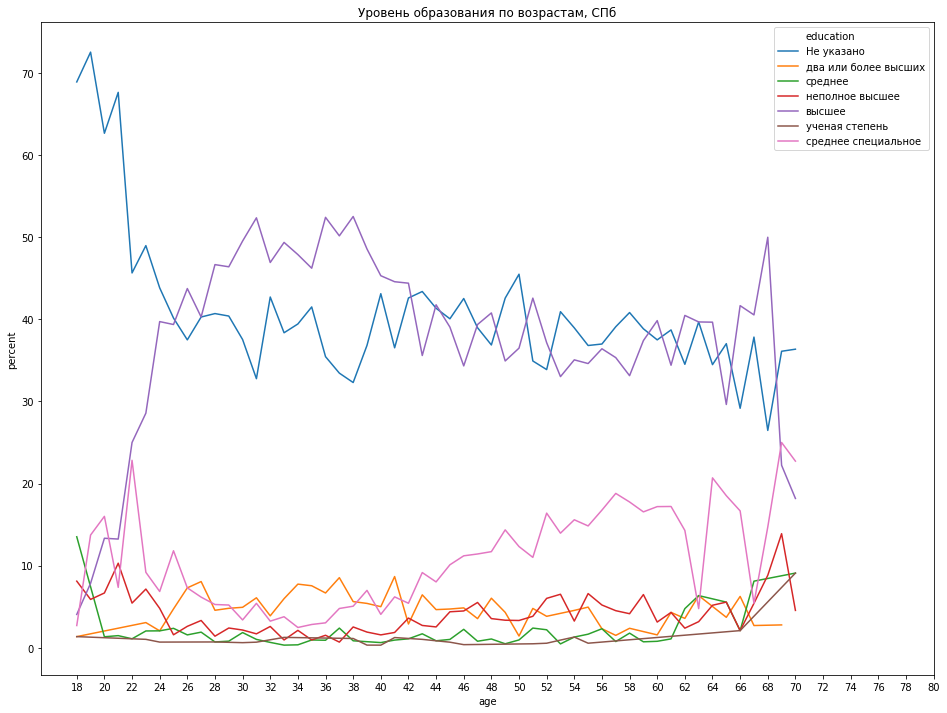

In [96]:
show_params_by_age(spbf, 'education', 'Уровень образования по возрастам, СПб')

Как и в Москве, доля не указывающих образование с довольно высоких значений быстро снижается, достигая минимума в 38 лет, после чего колеблется в районе 39%, постепенно снижаясь.

Доля высшего образования, как и в Москве, очень быстро растет, достигая максимума (примерно 52%) в 33, 38 и 40 лет, после чего падает и колеблется вокруг 39%. 

Неполное высшее растет до 21 года, а затем быстро падает примерно до 39 лет, после чего постепенно начинает повышаться. Доля двух и более высших растет до 27 лет, после чего снижается. Доля среднего специального непоследовательно растет, достигая максимума в 24% в 23 года, после чего снижается, но начиная с 35 постепенно растет. Доли среднего образования и ученой степени стабильно близки к нулю, несколько повышаясь после 62 лет.

<h3>11. Наличие детей</h3>

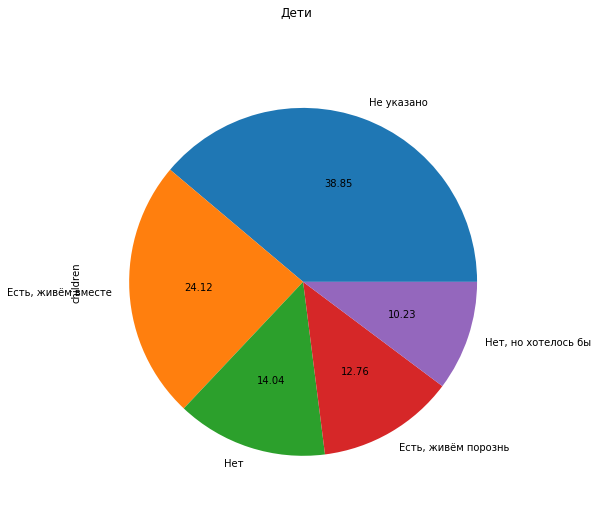

In [97]:
mf['children'] = mf['children'].fillna('Не указано')
show_pie_chart(mf, 'children', 'Дети')

В Москве больше трети не ответили на вопрос о наличии детей, у примерно такого же количества дети есть (2/3 из них живут вместе с детьми), а нет детей у оставшихся 24% (из них хотят детей чуть меньше половины).

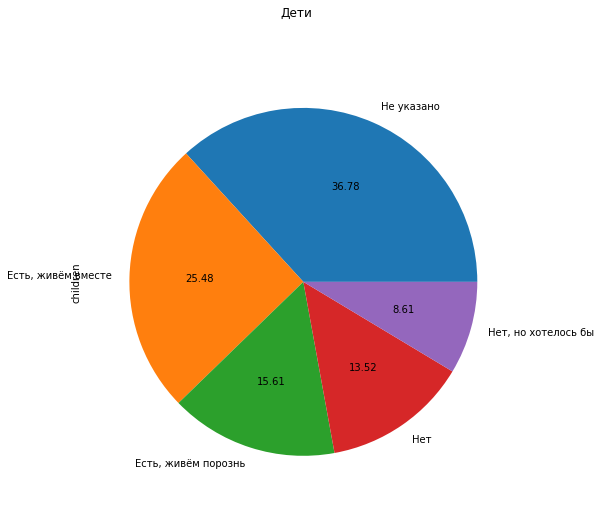

In [98]:
spbf['children'] = spbf['children'].fillna('Не указано')
show_pie_chart(spbf, 'children', 'Дети')

В отличие от Москвы, в СПб имеющих детей больше (41%), чем не ответивших на вопрос. Не имеющих детей несколько меньше, чем в Москве (примерно 22%).

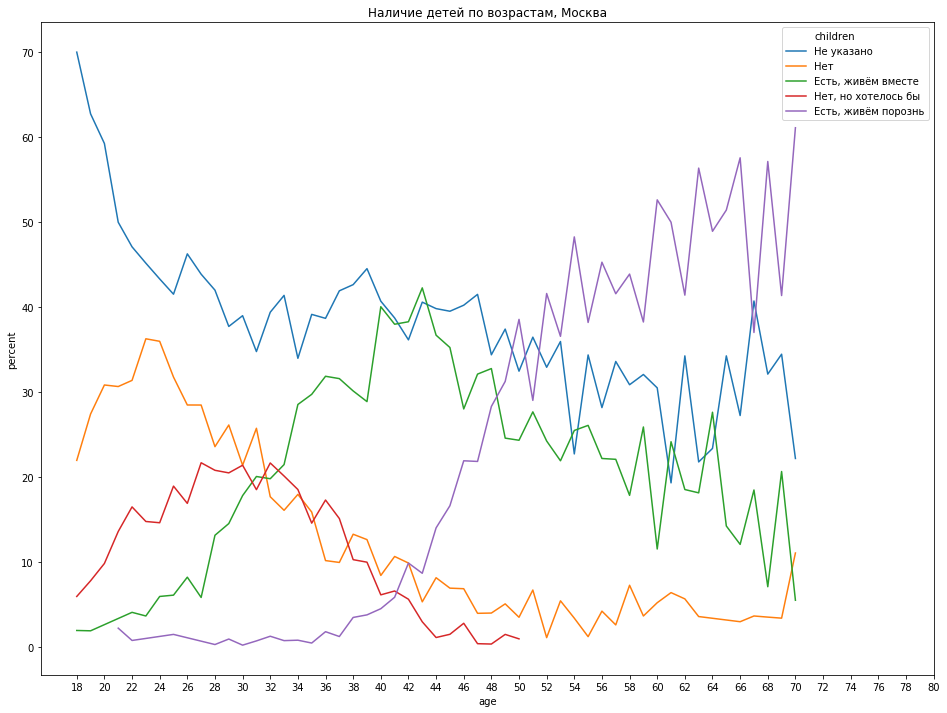

In [99]:
show_params_by_age(mf, 'children', 'Наличие детей по возрастам, Москва')

Итак, в Москве доля не указавших наличие детей, начинаясь с 70% в 18 лет, падает почти все время, хотя и непоследовательно. Популярность ответа "нет детей" растет до 26 лет, после чего начинает устойчиво снижаться, выйдя на колебания вокруг 5% после 50 лет. Ответ "Нет, но хотелось бы" растет с небольшой популярности в 7% примерно до 28 лет, оставаясь на этом уровне до 34 лет, после чего падает до 50 лет, где и прекращает встречаться. 

Доля живущих вместе с детьми постоянно растет, достигая максимума (42%) примерно в 44 года, после чего так же стабильно начинает падать. Доля живущих отдельно от детей начинает отличаться от нуля только в 21 год, оставаясь на стабильно низком уровне примерно до 35, демонстрируя после этого быстрый рост до самого конца. 

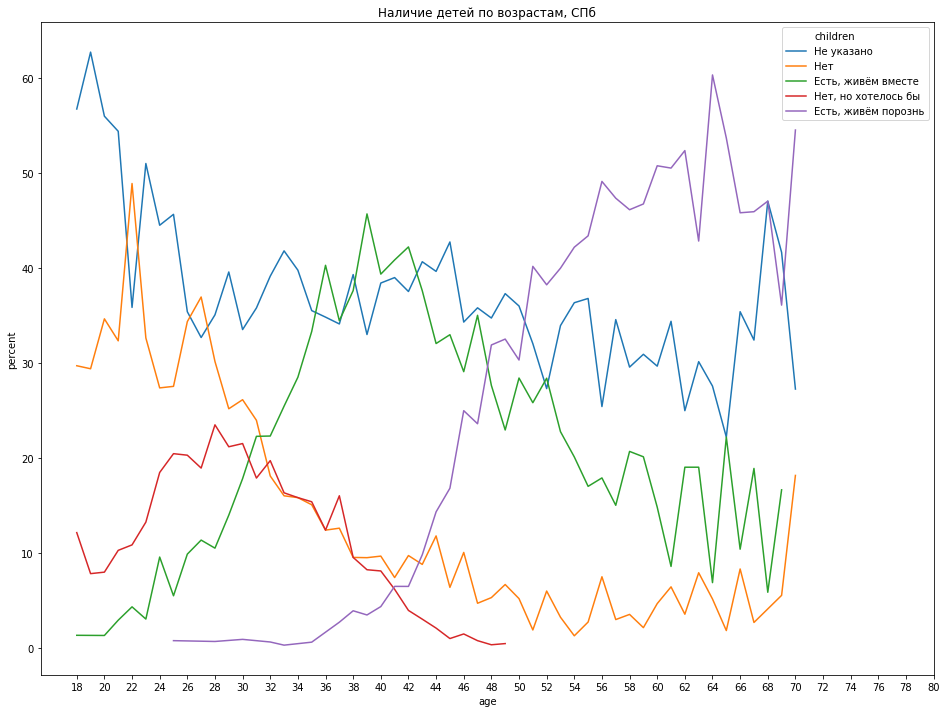

In [100]:
show_params_by_age(spbf, 'children', 'Наличие детей по возрастам, СПб')

В СПб доля не указавших наличие детей резко колеблется, но в целом падает. Популярность ответа "нет детей" растет до 23 лет, после чего начинает устойчиво снижаться, выйдя на колебания вокруг 5% после 50 лет. Доля ответа "Нет, но хотелось бы" после начального значения в 12% в 18 лет падает до 8%, а далее растет примерно до 29 лет, после чего падает до 50 лет, где и прекращает встречаться.

Доля живущих вместе с детьми постоянно растет, достигая максимума (45%) примерно в 40 лет, после чего так же стабильно начинает падать. Доля живущих отдельно от детей начинает отличаться от нуля только в 25 лет, оставаясь на стабильно низком уровне примерно до 35, демонстрируя после этого быстрый рост до 63 лет, после чего начинает испытывать резкие колебания.

<h3>12. Жилищные условия</h3>

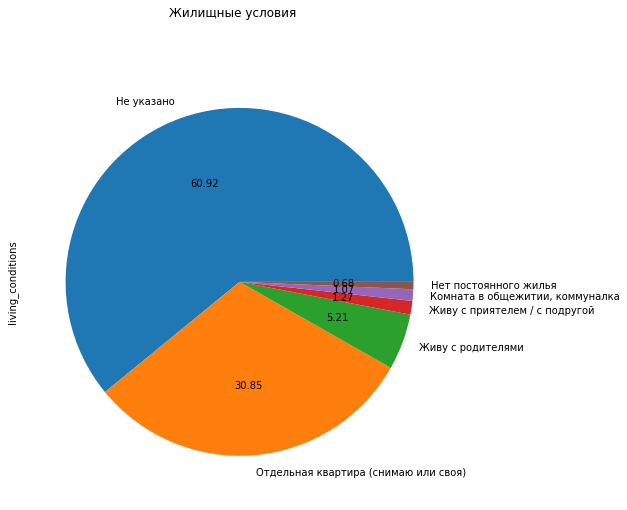

In [101]:
mf['living_conditions'] = mf['living_conditions'].fillna('Не указано')
show_pie_chart(mf, 'living_conditions', 'Жилищные условия')

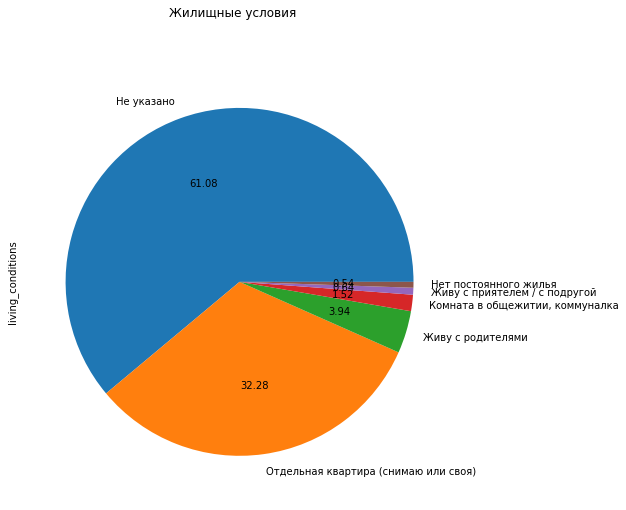

In [102]:
spbf['living_conditions'] = spbf['living_conditions'].fillna('Не указано')
show_pie_chart(spbf, 'living_conditions', 'Жилищные условия')

В общем распределение долей вариантов жилищных условий в Москве и СПб достаточно схоже. С родителями и с приятелем/подругой живет больше москвичек, а в общежитии/коммуналке - больше петербурженок.

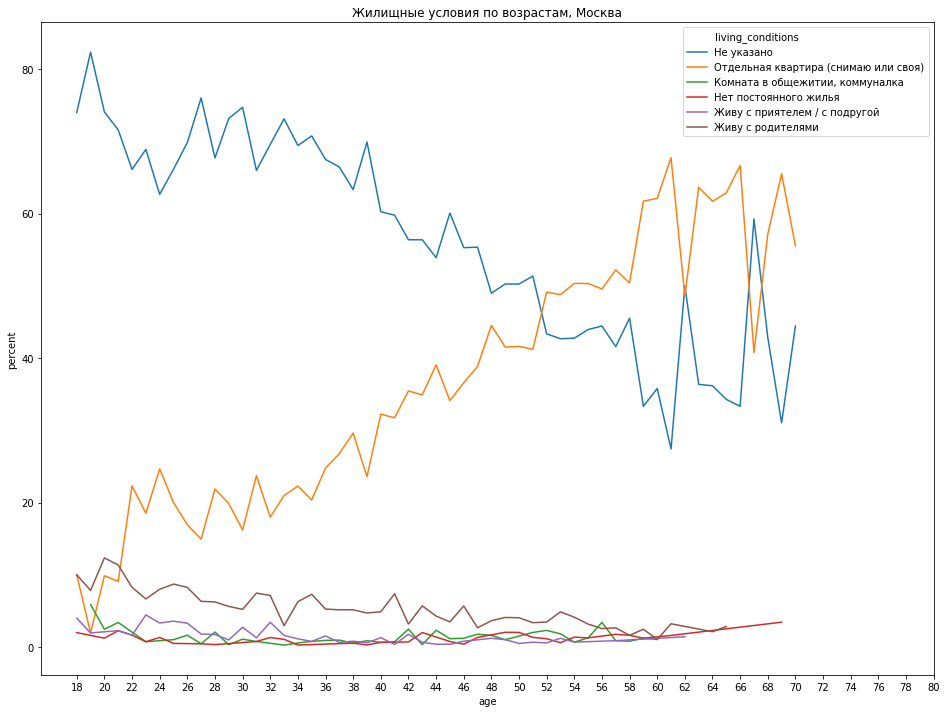

In [103]:
show_params_by_age(mf, 'living_conditions', 'Жилищные условия по возрастам, Москва')

В Москве доля скрывающих свое жилищное положение устойчиво падает с возрастом примерно до 64 лет, после чего начинает колебаться в широких пределах. Почти зеркально растет доля проживающих отдельно. Доля живущих с родителями медленно, но устойчиво падает, окончательно исчезая в 65 лет. Все прочие варианты остаются примерно на одном уровне чуть выше нуля. Из них только вариант "нет постоянного жилья" остается в числе выбранных до 70 лет.

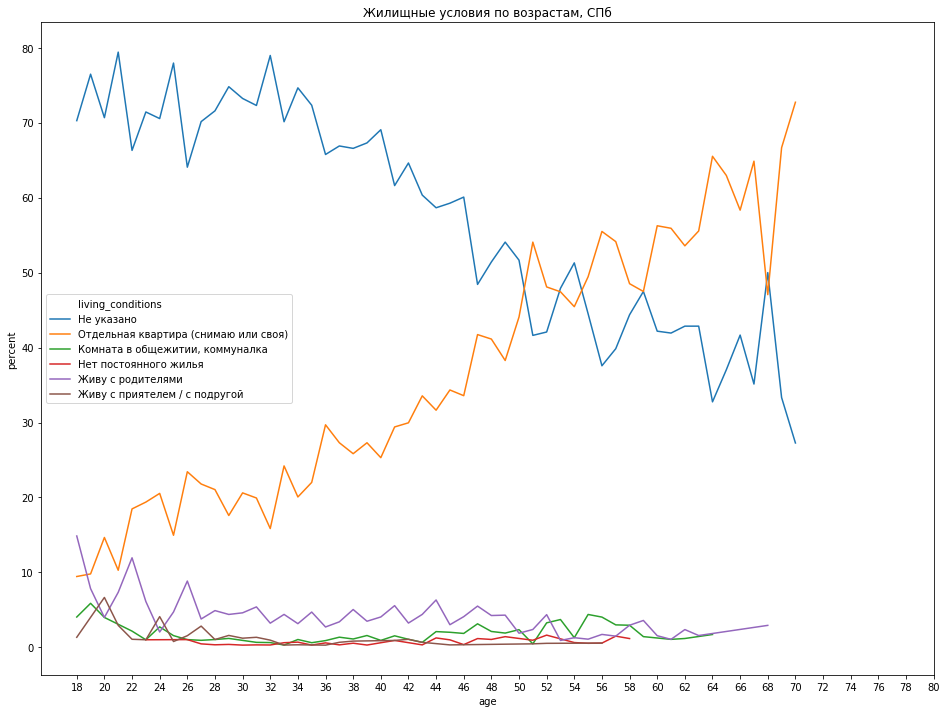

In [104]:
show_params_by_age(spbf, 'living_conditions', 'Жилищные условия по возрастам, СПб')

В СПб, как и в Москве доля скрывающих свое жилищное положение устойчиво падает с возрастом примерно до 68 лет, после чего начинает колебаться в широких пределах. Почти зеркально растет доля проживающих отдельно. Доля живущих с родителями сильно колеблется: размах колебаний максимален в юном возрасте и минимален с 28 до 40 лет, а в более старших возрастах сама доля несколько снижается.

Все прочие варианты начинают колебаться с постепенно уменьшающимся размахом, практически постоянны от 30 до 43 лет, после чего доля вариантов "Нет постоянного жилья" и "Общежитие/коммуналка" начинает расти. Все они исчезают к 70 лет.

<h3>13. Материальное положение</h3>

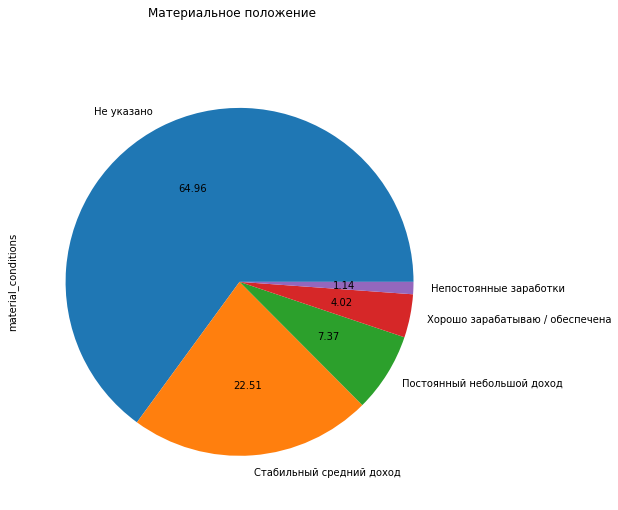

In [105]:
mf['material_conditions'] = mf['material_conditions'].fillna('Не указано')
show_pie_chart(mf, 'material_conditions', 'Материальное положение')

Итак, в Москве не указали свое материальное положение почти что 2/3, но из указавших примерно половина имеет стабильный средний доход.

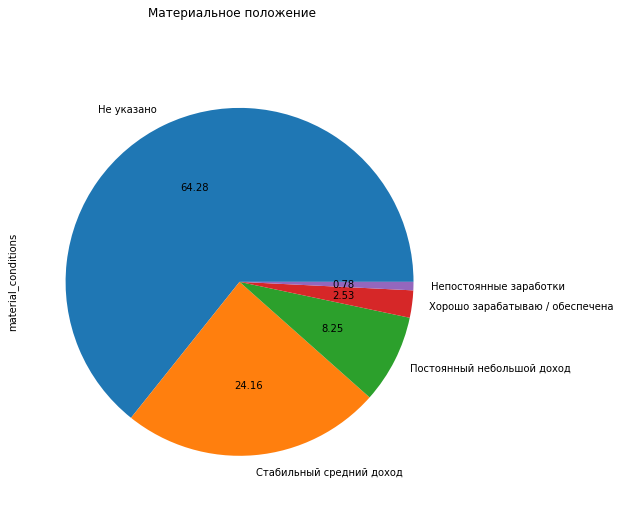

In [106]:
spbf['material_conditions'] = spbf['material_conditions'].fillna('Не указано')
show_pie_chart(spbf, 'material_conditions', 'Материальное положение')

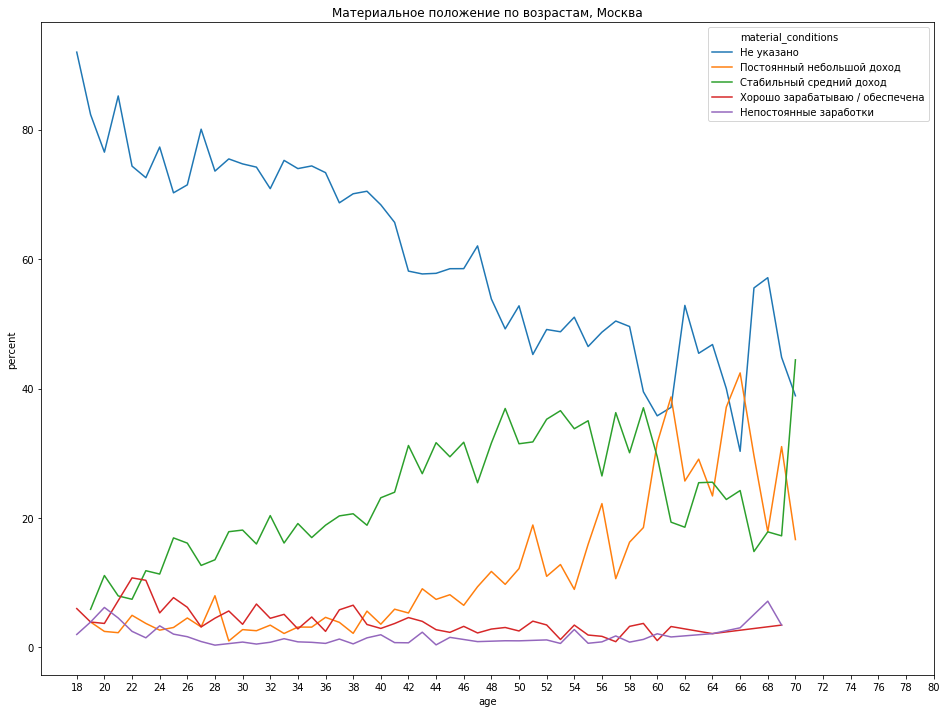

In [107]:
show_params_by_age(mf, 'material_conditions', 'Материальное положение по возрастам, Москва')

В Москве доля скрывших свой доход с повышением возраста падает, хотя и непоследовательно - особенно после 62 лет. Доля стабильного среднего дохода начинается в 19 лет и растет примерно до 52 лет, после чего начинает падать. Доля постоянного небольшого дохода держится примерно на одном уровне с 19 до 40 лет, после чего устойчиво растет. Доля непостоянных заработков держится в узких пределах, не выходя за 10%, но демонстрирует слабый устойчивый рост после 54 лет. Доля обеспеченных быстро растет до  23 лет, после чего довольно медленно снижается, находясь на несколько процентов выше доли непостоянных заработков.

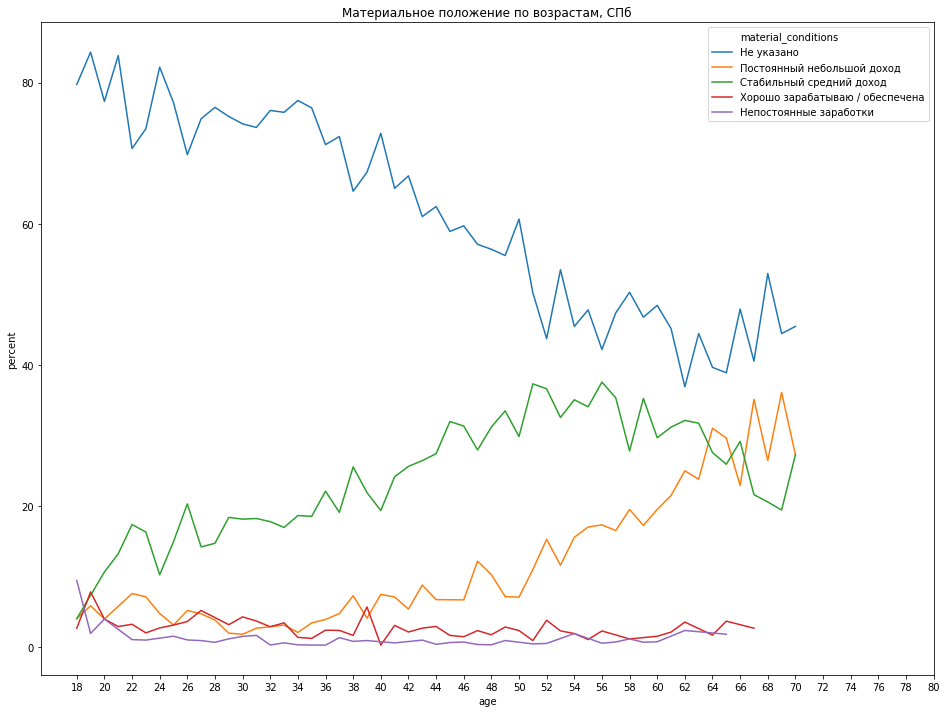

In [108]:
show_params_by_age(spbf, 'material_conditions', 'Материальное положение по возрастам, СПб')

В СПб, как и в Москве доля скрывших свой доход с повышением возраста падает, хотя и непоследовательно - особенно после 63 лет. Доля стабильного среднего дохода растет примерно до 52 лет, после чего начинает падать. Доля постоянного небольшого дохода держится примерно на одном уровне с 19 до 40 лет, после чего устойчиво растет. Доля непостоянных заработков держится в узких пределах, не выходя за 10%, как и доля обеспеченных - но последняя на несколько процентов выше первой почти во всех возрастах.

<h3>14. Отношение к алкоголю</h3>

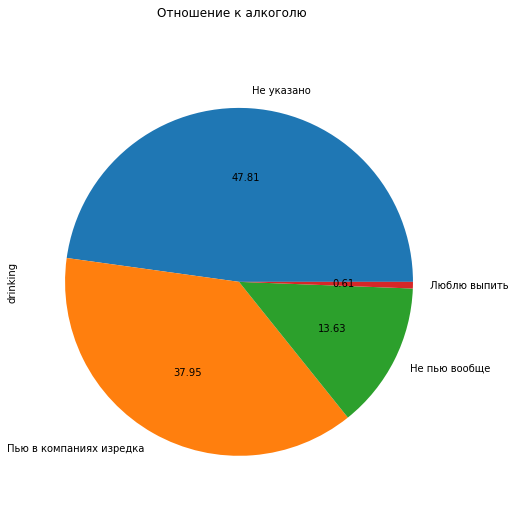

In [109]:
mf['drinking'] = mf['drinking'].fillna('Не указано')
show_pie_chart(mf, 'drinking', 'Отношение к алкоголю')

Скрывают свое отношение к алкоголю почти половина владелиц анкет из Москвы, но пьют изредка или не пьют вообще почти все из оставшихся - любительниц выпить меньше процента.

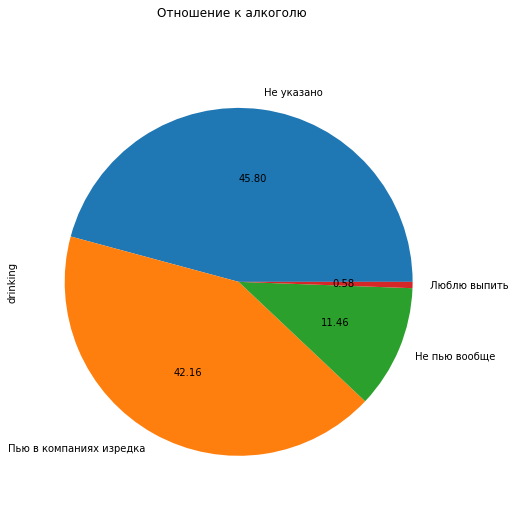

In [110]:
spbf['drinking'] = spbf['drinking'].fillna('Не указано')
show_pie_chart(spbf, 'drinking', 'Отношение к алкоголю')

В СПб очень схожая с Москвой картина, только несколько процентов перекочевало из разряда непьющих к пьющим изредка.

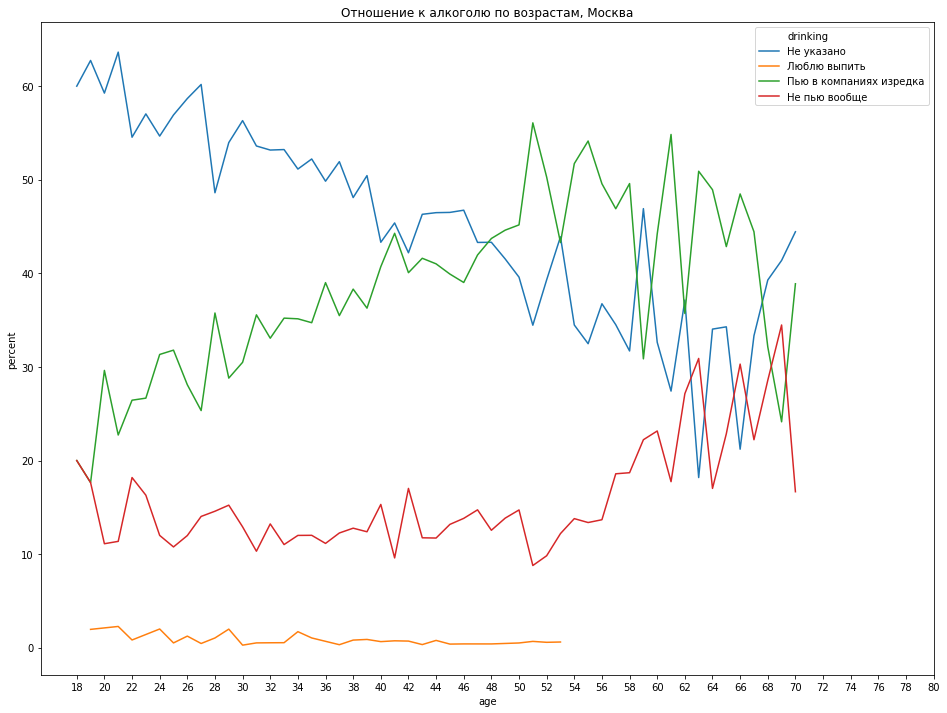

In [111]:
show_params_by_age(mf, 'drinking', 'Отношение к алкоголю по возрастам, Москва')

В Москве доля любящих выпить почти не меняется с возрастом, но исчезает после 53 лет. Доля пьющих изредка с возрастом растет, достигая максимума (более половины) в 55 лет, после чего начинает колебаться в широких пределах.  Доля непьющих колеблется вокруг примерно 12%, но после 52 лет идет вверх. Доля скрывающих свое отношение к алкоголю с возрастом падает, почти зеркально отражая долю пьющих изредка.

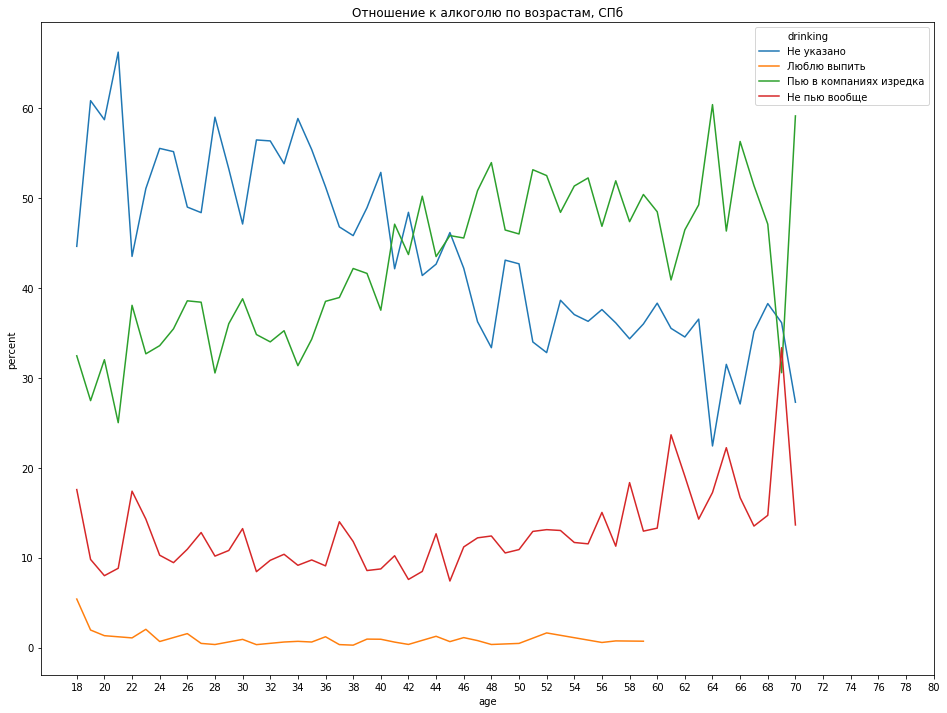

In [112]:
show_params_by_age(spbf, 'drinking', 'Отношение к алкоголю по возрастам, СПб')

В СПб, как и в Москве, доля любящих выпить почти не меняется с возрастом, но исчезает после 59 лет. Доля пьющих изредка с возрастом растет, достигая максимума (более половины) в 48 лет, после чего начинает колебаться в широких пределах.  Доля непьющих колеблется вокруг примерно 12%, но после 48 лет идет вверх. Доля скрывающих свое отношение к алкоголю с возрастом падает, почти зеркально отражая долю пьющих изредка.

<h3>15. Отношение к курению</h3>

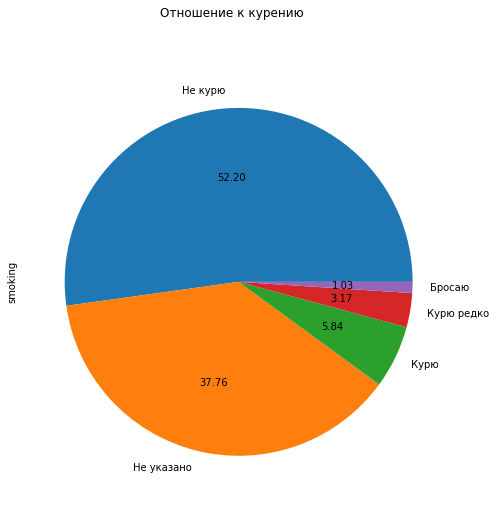

In [113]:
mf['smoking'] = mf['smoking'].fillna('Не указано')
show_pie_chart(mf, 'smoking', 'Отношение к курению')

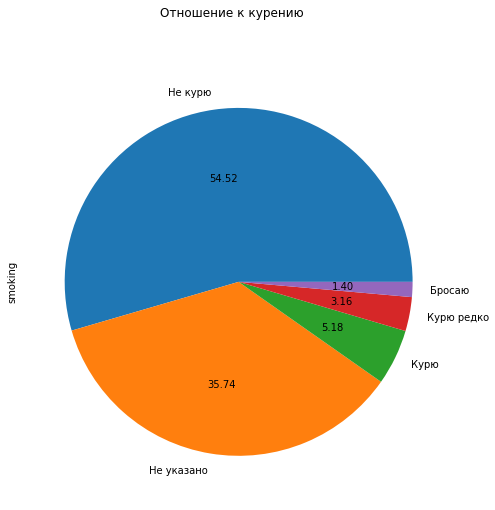

In [114]:
spbf['smoking'] = spbf['smoking'].fillna('Не указано')
show_pie_chart(spbf, 'smoking', 'Отношение к курению')

И в Москве, и в СПю не курит чуть больше половины. Не указывают свое отношение к этой вредной привычке около 40%, курят около 6%, редко курят примерно 3%, а один процент бросает.

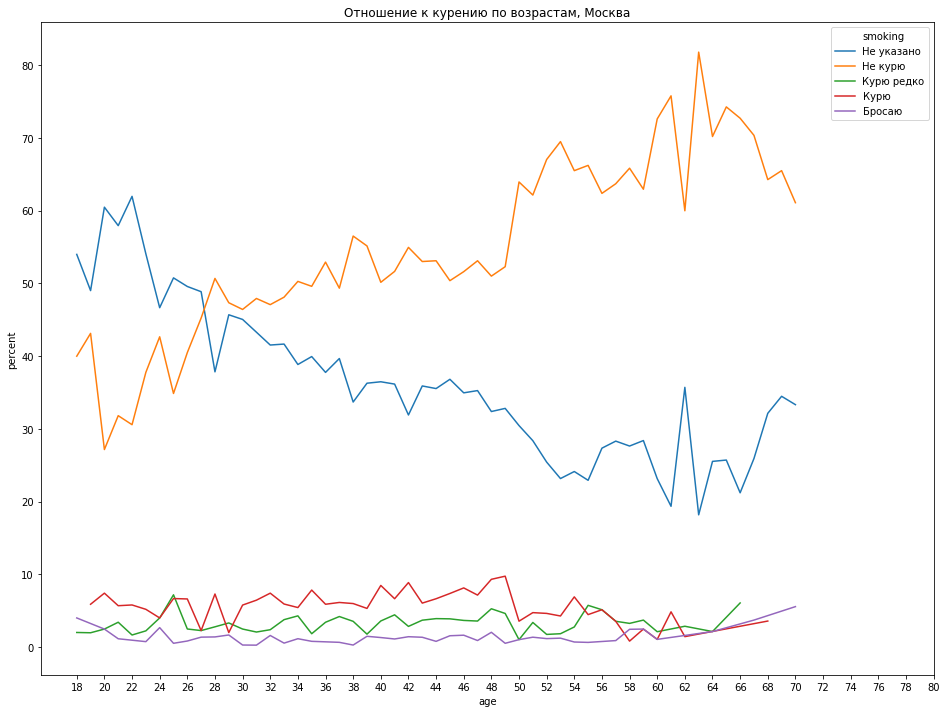

In [115]:
show_params_by_age(mf, 'smoking', 'Отношение к курению по возрастам, Москва')

Судя по анкетам, постоянно курить женщины в Москве начинают с 19 лет. Доля курящих медленно растет, достигая 10% к 49 годам, после чего падает примерно наполовину, и дальше непоследовательно снижается, к 68 годам исчезая. Бросать же начинают сразу с 18 - доля бросающих находится примерно на одном уровне до 60 лет, после чего плавно повышается. Доля курящих редко повышается до максимума в 8% к 25 годам, после чего опускается и колеблется примерно на одном уровне, исчезая в 66 лет. Некурящие и неуказавшие свое отношение к курению зеркально отражают друг друга: после колебаний в 18-19 лет доля первых стабильно растет, а вторых - снижается. Только после 62 лет вновь начинаются резкие колебания.

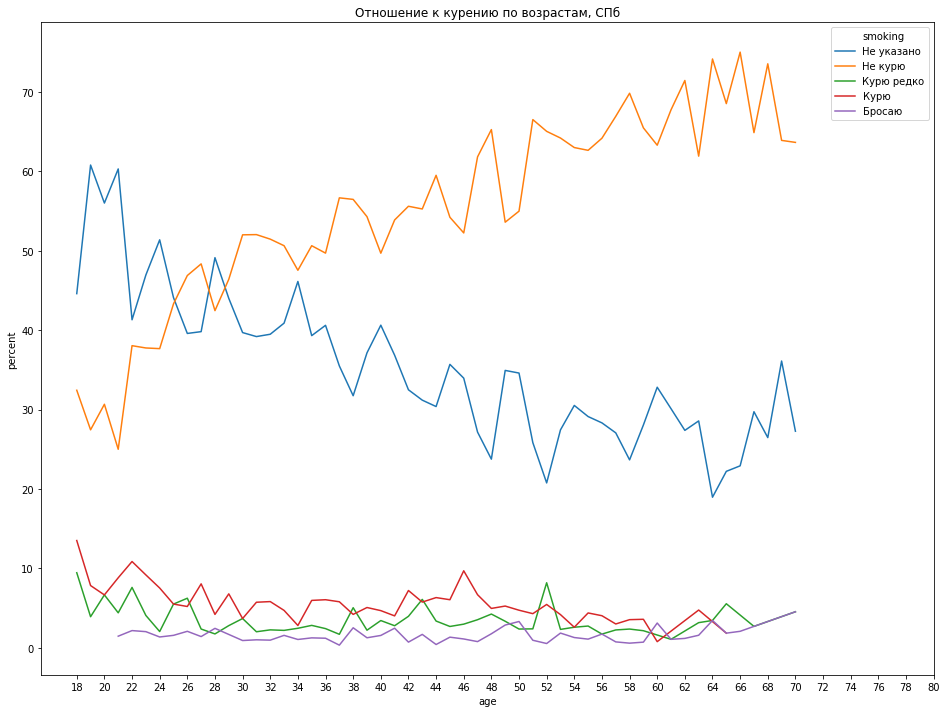

In [116]:
show_params_by_age(spbf, 'smoking', 'Отношение к курению по возрастам, СПб')

Доля курящих в СПб, в отличие от Москвы, с 14% в 18 лет медленно снижается, но с 34 лет начинает медленно расти, доходя до второго максимума в 47 лет, после чего снижается уже окончательно. Бросать же начинают только с 21 года - и доля бросающих стабильно мала, хотя и немного увеличивается после 58, исчезая в 68. 

Доля курящих редко, колеблясь, снижается до 37 лет, после чего, демонстрируя подъемы в 43 и 53 года, остается примерно на одном уровне до 61 года, когда начинает проявляться тенденция к повышению. 

Некурящие и неуказавшие свое отношение к курению отражают друг друга, хотя и не так так зеркально, как в Москве: после колебаний в 18-22 года доля первых стабильно растет, а вторых - снижается. Колебания после 64 лет не так сильно выражены, как в Москве.

<h3>16. Отношения</h3>

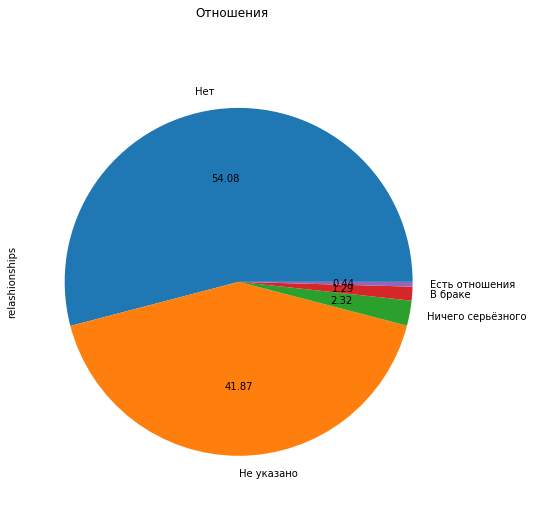

In [117]:
mf['relashionships'] = mf['relashionships'].fillna('Не указано')
show_pie_chart(mf, 'relashionships', 'Отношения')

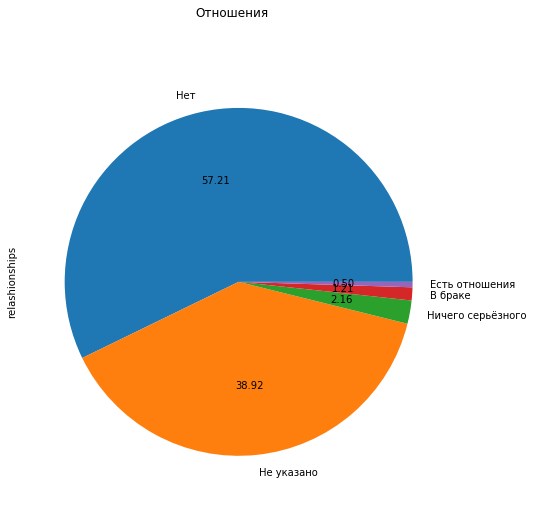

In [118]:
spbf['relashionships'] = spbf['relashionships'].fillna('Не указано')
show_pie_chart(spbf, 'relashionships', 'Отношения')

Итак, в СПб скрывают свой статус немного реже, чем в Москве, в остальном же все очень похоже: нет отношений у более чем половины.

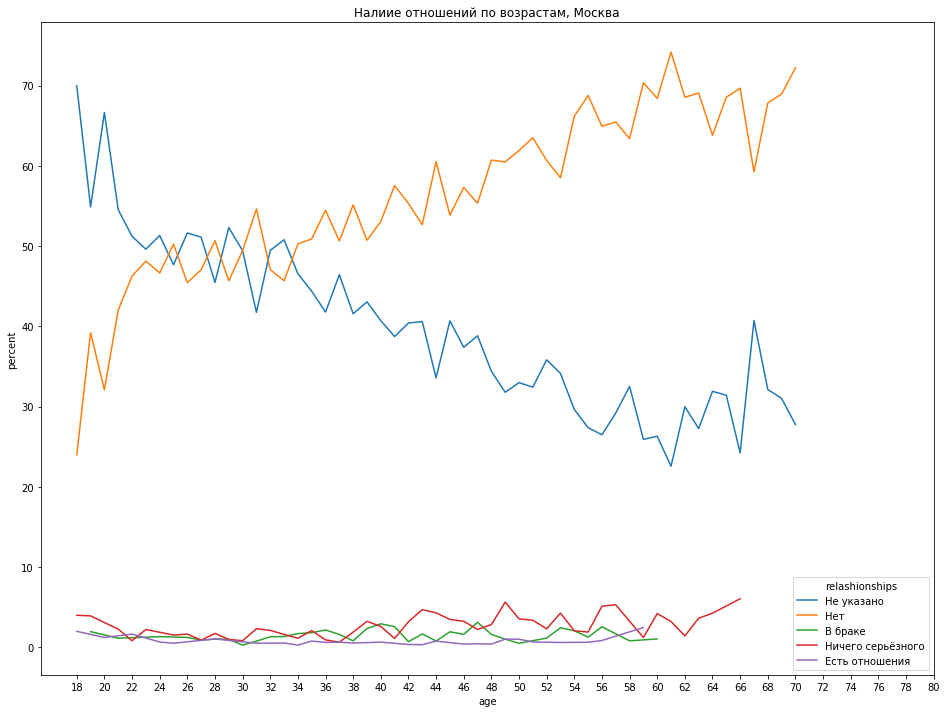

In [119]:
show_params_by_age(mf, 'relashionships', 'Налиие отношений по возрастам, Москва')

В Москве доля неуказанного статуса падает с возрастом, а доля ответа "нет отношений" зеркально увеличивается. Только после 64 лет начинаются значительные колебания.

Доля ответа "ничего серьезного" до 41 года почти стабильна, а после несколько увеличивается, исчезая после 66 лет. Прочие ответы держатся на стадильно низком уровне, исчезая после 61 года.

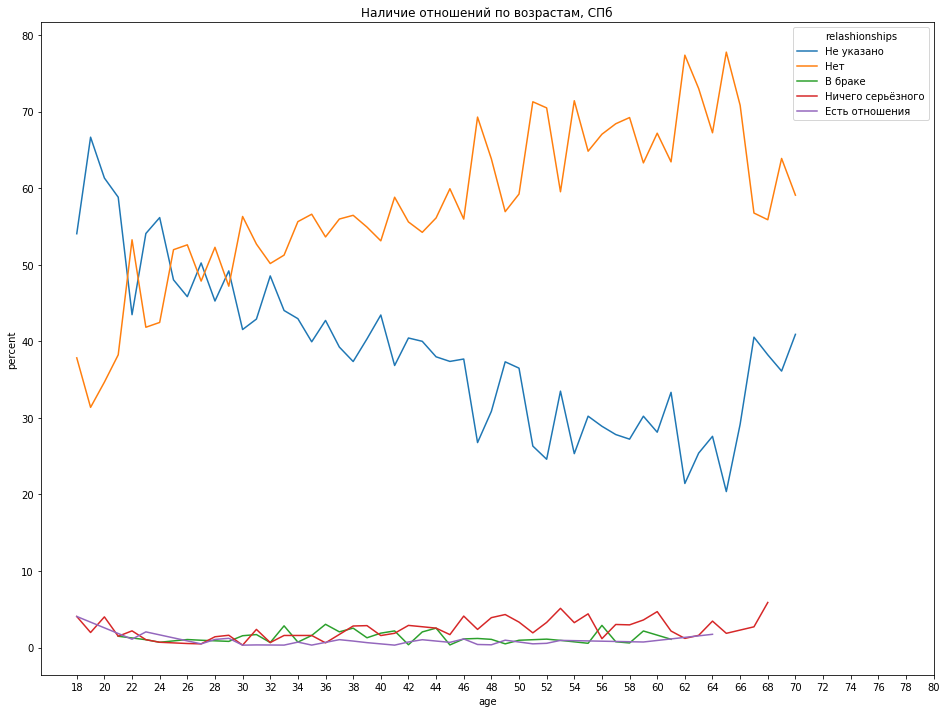

In [120]:
show_params_by_age(spbf, 'relashionships', 'Наличие отношений по возрастам, СПб')

Никаких принципиальных отличий СПб от Москвы не обнаруживается.

<h3>17. Интересы</h3>

In [121]:
mfi = mf[mf['interests']!='']
print("Доля анкет с указанными интересами в Москве: {0: 2.1f}%".format((100*len(mfi)/10000)))

Доля анкет с указанными интересами в Москве:  45.8%


In [122]:
spbfi = spbf[spbf['interests']!='']
print("Доля анкет с указанными интересами в СПб: {0: 2.1f}%".format(100*len(spbfi)/10000))

Доля анкет с указанными интересами в СПб:  49.0%


In [123]:
def get_interests(df):
    '''
        Получить список из списков интересов
    '''

    interests = []

    for interests_string in df['interests']:
        interests_list = interests_string.split(',')
        interests.append(interests_list)
        
    return interests

In [124]:
def show_interests(df, title):
    '''
        Посказать горизонтальную гистограмму топ-10 интересов
    '''
    
    interests = []

    for interests_string in df['interests']:
        interests_list = interests_string.split(',')
        interests.extend(interests_list)
        
    d3 = pd.DataFrame([{'interest': x} for x in interests])
    f, ax = plt.subplots(figsize=(10, 8))
    sns.countplot(y='interest', data=d3, order=d3['interest'].value_counts().iloc[:10].index).set_title(title)

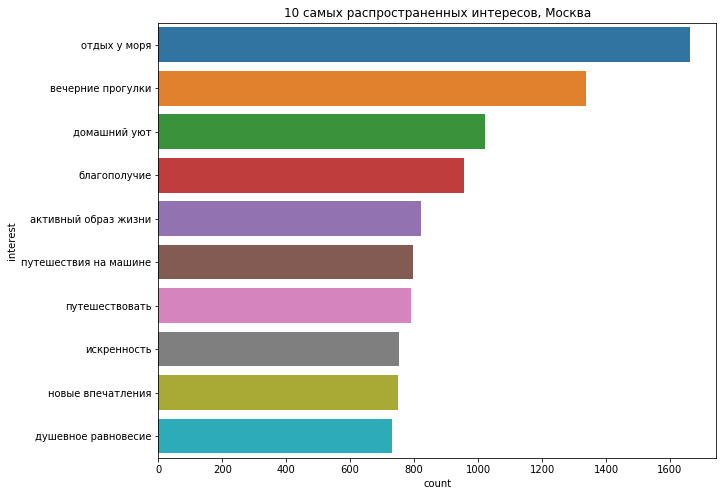

In [125]:
show_interests(mfi, '10 самых распространенных интересов, Москва')

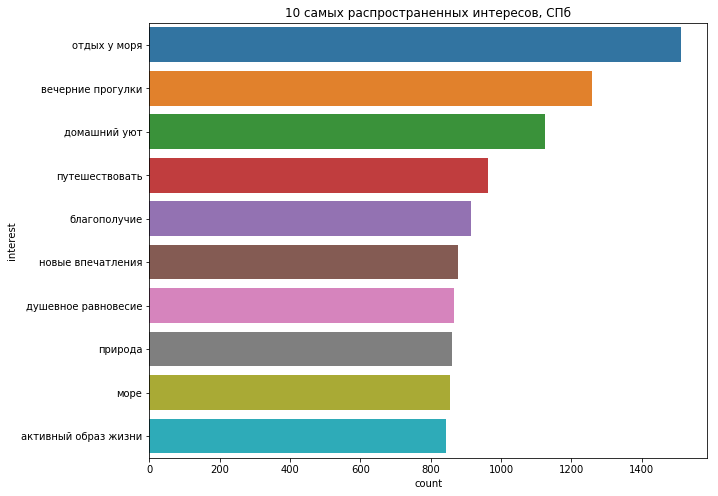

In [126]:
show_interests(spbfi, '10 самых распространенных интересов, СПб')

Таким образом, первая тройка наиболее частых интересов в Москве и СПб совпадают: это отдых у моря, вечерние прогулки и домашний уют.

Попробуем найти самые распространенные пары интересов, встречающиеся вместе.

In [127]:
mf_interests = get_interests(mfi)
spbf_interests = get_interests(spbfi)

In [128]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

def show_frequent_pairs(interests):
    te = TransactionEncoder()
    te_ary = te.fit(interests).transform(interests)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 2]
    
    frequent_list = list(frequent_itemsets.sort_values(by=['support'], ascending=False)['itemsets'])[:10]
    
    for f in frequent_list:
        print(', '.join(f))

In [129]:
print('Пары интересов, топ-10, Москва:\n') 
show_frequent_pairs(mf_interests)

Пары интересов, топ-10, Москва:

отдых у моря, вечерние прогулки
отдых у моря, путешествия на машине
благополучие, отдых у моря
самостоятельные путешествия, отдых у моря
благополучие, вечерние прогулки
активный образ жизни, отдых у моря
активный отдых, отдых у моря
домашний уют, искренность
домашний уют, душевное равновесие
домашний уют, доброта


In [130]:
print('Пары интересов, топ-10, СПб:\n') 
show_frequent_pairs(spbf_interests)

Пары интересов, топ-10, СПб:

вечерние прогулки, отдых у моря
отдых у моря, путешествия на машине
домашний уют, семья
активный образ жизни, отдых у моря
домашний уют, душевное равновесие
благополучие, отдых у моря
путешествовать, море
домашний уют, искренность
самостоятельные путешествия, отдых у моря
благополучие, вечерние прогулки


Попробуем оценить популярность первых трех интересов по возрастам.

In [131]:
mf['seaside_rest'] = mf['interests'].apply(lambda x: 1 if 'отдых у моря' in x else 0)
mf['evening_walks'] = mf['interests'].apply(lambda x: 1 if 'вечерние прогулки' in x else 0)
mf['home_sweet_home'] = mf['interests'].apply(lambda x: 1 if 'домашний уют' in x else 0)

spbf['seaside_rest'] = spbf['interests'].apply(lambda x: 1 if 'отдых у моря' in x else 0)
spbf['evening_walks'] = spbf['interests'].apply(lambda x: 1 if 'вечерние прогулки' in x else 0)
spbf['home_sweet_home'] = spbf['interests'].apply(lambda x: 1 if 'домашний уют' in x else 0)

In [132]:
def show_interest_by_age(df, interest, title):
    '''
        Показать процент присутствия конкретного интереса в списке
    '''

    ages = {
        'Москва': dict(df[df['city']=='Москва']['selfAge'].value_counts()),
        'СПб': dict(df[df['city']=='СПб']['selfAge'].value_counts()),
    }
    dfi = df.groupby(['selfAge', 'city']).agg({interest: 'sum'})                        
    interest_pc = []
    interest_pc = [ew/ages[di[1]][di[0]] for ew, di in zip(dfi[interest], dfi.index)]
    dfi['city'] = [ind[1] for ind in dfi.index]
    dfi[interest] = interest_pc
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.lineplot(x=[ind[0] for ind in dfi.index], y=interest, data=dfi, hue='city')
    ax.set_xticks(np.arange(18, 71, 2));
    ax.set_yticks(np.arange(0, 0.3, 0.1));
    ax.set_title(title);

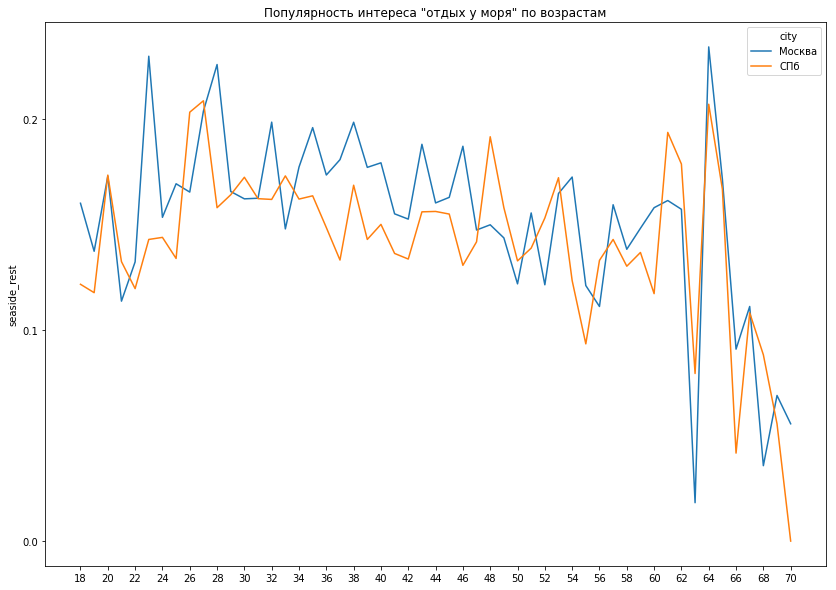

In [133]:
mf['city'] = 'Москва'
spbf['city'] = 'СПб'
f = pd.concat([mf, spbf], sort=False)
show_interest_by_age(f, 'seaside_rest', 'Популярность интереса "отдых у моря" по возрастам')

Мы видим, что популярность отдыха у моря в целом повышается до определенного возраста (примерно 28 лет), после чего колеблется вокруг одного уровня (в Москве он выше, в СПб - ниже) примерно до 48 лет в Москве и 52 лет в СПб и начинает снижаться, хотя после 62 налюдаются сильные колебания.

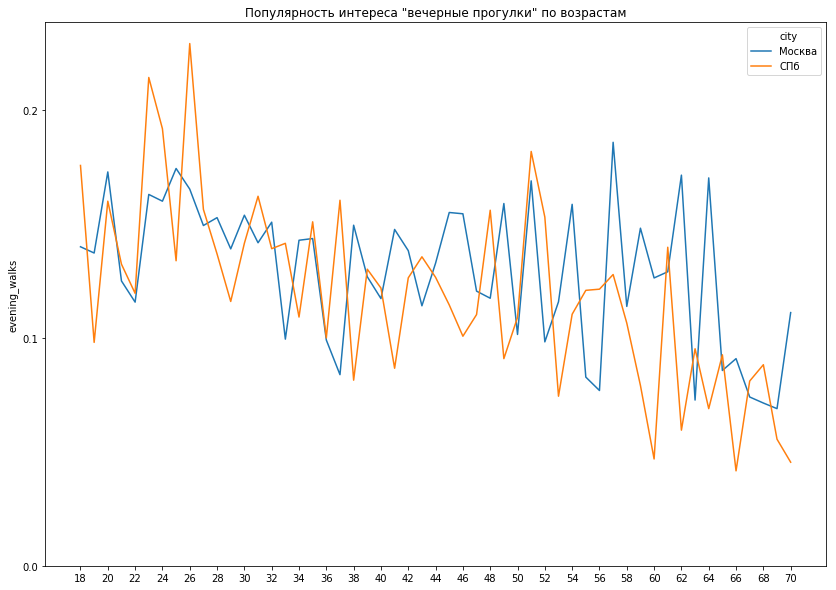

In [134]:
show_interest_by_age(f, 'evening_walks', 'Популярность интереса "вечерные прогулки" по возрастам')

Можно сказать, что популярность вечерних прогулок в Москве колеблется вокруг определенного значения во всех возрастах. В СПб же она сначала демонстрирует тенденцию к повышению, и после максимума примерно в 28 лет начинает медленно падать.

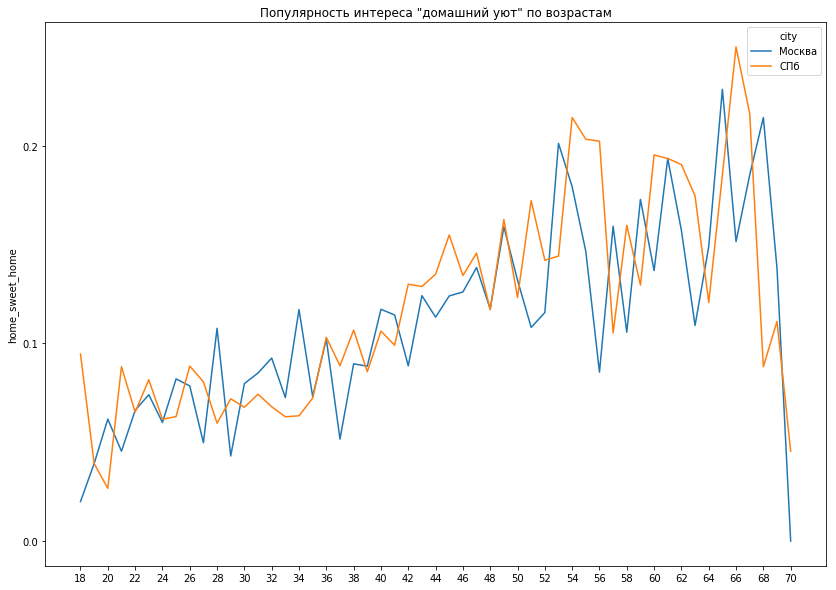

In [135]:
show_interest_by_age(f, 'home_sweet_home', 'Популярность интереса "домашний уют" по возрастам')

Популярность домашнего уюта в обоих городах с возрастом только растет. В СПб, в отличие от Москвы, наблюдаются сильные колебания в 18-20 лет.

<h2>ВЫВОДЫ</h2>

В обоих городах топ-10 имен одинаков, меняется только порядок. И в Москве, и в СПб на первом месте находится Елена, на втором - Наталья. Третье место у Ольги (Москва) и Татьяны (СПб). В обоих городах на имена из топ-10 приходится около половины всех анкет.

В Москве преобладают рожденные летом и весной (первая тройка - лето, вторая тройка - весна). В СПб эта закономерность не имеет такого отчетливого характера: на 1-м, 2-м и 4-м месте находятся рожденные летом, на 2-м - весной.

По среднему (39 лет) и медианному (38 лет) возрасту СПб опережает Москву примерно на 2 года. В Москве в топ-10 представлен исключительно возраст от 30 до 40 лет, в СПб - от 30 до 45 лет.

И в Москве, и в СПб указывают желаемый возраст партнера подавляющее большинство, ~ 97%. В обоих городах медианный желаемый возраст до определенного возраста владелицы анкеты (47 лет в СПб, 49 лет в Москве) всегда выше (на 3-4 года), чем возраст, указанный в анкете. Далее разница колеблется возле нуля, а размах границ желаемого возраста устойчиво растет. 

И в Москве, и в СПб подавляющее большинство (~98%) хочет познакомиться исключительно с лицом противоположного пола.
 
В обоих городах вес указан в примерно половине анкет: 47% в СПб и 49% в Москве. Медианный и средний веса в Москве и СПб можно считать одинаковыми - 60 кг и 62 кг. В обоих городах средний вес устойчиво растет с возрастом.
 
Процент анкет с указанным ростом в Москве и СПб примерно одинаков: 72% и 74%. В Москве и СПб рост растет до 29 лет, но в СПб размах колебаний намного выше. После этого возраста он устойчиво снижается. Почти во всех возрастах средний рост в СПб несколько ниже московского. 
 
Что касается телосложения, то распределение по долям в Москве и в СПб практически одинаковое: около половины не указывают его, у чуть более трети оно обычное, у 10% - спортивное, прочие варианты малораспространены. 
Доля не указавших свое телосложение как в Москве, так и в СПб со возрастом снижается более чем вдвое. Одновременно растет доля обычного телосложения. Доля спортивного телосложения не превышает 15% ни в каком возрасте и со временем снижается. Мускулистое телосложение отмечается только на отрезке от 29 до 55 лет в Москве и от 30 до 63 лет в СПб.
 
Как и Москве, таки в СПб примерно 81% не владеют ни одним иностранным языком. Меньше 16% владеют одним английским, менее 2% - одним немецким. Прочие варианты имеют крайне малую частоту. В СПб в первую пятерку вошла только одна пара языков в отличие от двух в Москве (пару "французский и английский" здесь заменил французский). В обоих городах доля анкет с одним русским языком колеблется возле отметки в 80%, спускаясь до минимальных значений в диапазоне от 30 до 40 лет, когда повышается доля владения английским. Владение немецким встречается стабильно редко до 46 лет, но растет в последующие годы.

Распределение образовательных уровней в двух городах несколько отличается. В СПб и Москве лидерами являются "не указано" и "высшее образование" (оба примерно равны, ~40%). Но на третьем месте в СПб не два или более высших, как в Москве, а среднее специальное. В СПб ниже доля ученых степеней, но выше - неполного высшего. Можно сделать вывод, что в общем уровень образования в петербургских анкетах несколько ниже московского. В обоих городах доля не указывающих свое образование с довольно высоких значений быстро снижается, достигая минимума в 38 лет. После этого в Москве она растет до 48 лет, а в СПб колеблется в районе 39%, постепенно снижаясь. И в Москве, и в СПб доля высшего образования очень быстро растет, достигая максимума. Но в Москве он наступает в 29 лет, а далее эта доля колеблется, постепенно снижаясь. В СПб же максимумы встречаются позже - в 33, 38 и в 40 лет, и после этого доля высшего образования падает и колеблется вокруг 39%. В обоих городах доля неполного высшего образования растет до 21-22 лет, а затем быстро падает примерно до 39-42 лет, где постепенно начинает повышаться. Доля двух и более высших растет, доходя до максимума в 36 лет (в СПб - в 27), после чего снижается. В Москве доля среднего специального быстро растет к 20 годам, поcле чего снижается, но начиная с 28 постепенно растет, выходя в 68 лет на второе место. В СПб же она непоследовательно растет, достигая максимума в 24% в 23 года, после чего снижается, но начиная с 35 лет постепенно растет. Доли среднего образования и ученой степени стабильно близки к нулю в обоих городах.

На вопрос о наличии детей в Москве не ответили больше трети. У примерно такого же количества дети есть (2/3 из них живут вместе с детьми), а нет детей у оставшихся 24% (из них хотят детей чуть меньше половины). В отличие от Москвы, в СПб имеющих детей больше (41%), чем не ответивших на вопрос, а не имеющих детей несколько меньше, чем в Москве (примерно 22%). В обоих городах доля не указавших наличие детей падает с возрастом, хотя и непоследовательно (в СПб размах колебаний выше). Популярность ответа "нет детей" растет до 26 лет (в СПб - до 23), после чего начинает устойчиво снижаться, выйдя на колебания вокруг 5% после 50 лет. Доля ответа "Нет, но хотелось бы" растет примерно до 28-29 лет, после чего падает до 50 лет, где и прекращает встречаться. Доля живущих вместе с детьми в возратом стабильно растет, достигая максимума (42%, в СПб - 45%) примерно в 44 года (в СПб - 40 лет), после чего так же стабильно начинает падать. Доля живущих отдельно от детей начинает отличаться от нуля только в 25 лет (в СПб - 21), оставаясь на стабильно низком уровне примерно до 35, после чего растет в Москве, а в СПб - испытывает резкие колебания.

Распределение долей вариантов жилищных условий в Москве и СПб достаточно схоже. Скрывают свои жилищные условия примерно 61%, живут в отдельном жилище - примерно 31%. С родителями и с приятелем/подругой живет больше москвичек, а в общежитии/коммуналке - больше петербурженок. В Москве, как и в СПб, доля скрывающих свое жилищное положение устойчиво падает с возрастом примерно до 64 (в СПб - 68) лет, после чего начинает колебаться в широких пределах. Почти зеркально растет доля проживающих отдельно. В Москве доля живущих с родителями медленно, но устойчиво падает, окончательно исчезая в 65 лет. В СПБ она сильно колеблется: размах колебаний максимален в юном возрасте и минимален с 28 до 40 лет, а в более старших возрастах сама доля несколько снижается.

Пропорции типов доходов в Москве и СПб примерно одинаковы: не указали свое материальное положение почти что 2/3, а из указавших примерно половина имеет стабильный средний доход. Однако хорошо зарабатывает в процентном соотношении в два раза меньше владелиц анкет из СПб. В Москве и в СПб доля скрывших свой доход с повышением возраста падает, хотя и непоследовательно - особенно после 62 лет. Доля стабильного среднего дохода растет примерно до 52 лет, после чего начинает падать. Доля постоянного небольшого дохода держится примерно на одном уровне с 19 до 40 лет, после чего устойчиво растет. Доля непостоянных заработков держится в узких пределах, не выходя за 10%, а в СПб еще и демонстрирует слабый устойчивый рост после 54 лет. В Москве доля обеспеченных быстро растет до 23 лет, после чего довольно медленно снижается; в СПб она постоянна во всех возрастах. В обоих городах она находится на несколько процентов выше доли непостоянных заработков.

В Москве скрывают свое отношение к алкоголю почти половина владелиц анкет из Москвы, но из оставшихся пьют изредка (~38%) или не пьют вообще (~14%) почти все - любительниц выпить меньше процента. В СПб очень схожая с Москвой картина, только несколько процентов перекочевало из разряда непьющих к пьющим изредка. В обоих городах доля любящих выпить почти не меняется с возрастом, но исчезает после 53 лет (в СПб - 59 лет). Доля пьющих изредка с возрастом растет, достигая максимума (более половины) в 55 лет (в СПб - 48 лет), после чего начинает колебаться в широких пределах. Доля непьющих колеблется вокруг примерно 12%, но после 52 лет (в СПб - 48 лет) идет вверх. Доля скрывающих свое отношение к алкоголю с возрастом падает, почти зеркально отражая долю пьющих изредка.

И в Москве, и в СПб не курит чуть больше половины. Не указывают свое отношение к этой вредной привычке около 40%, курят около 6%, редко курят примерно 3%, а один процент бросает. В Москве доля курящих медленно растет, достигая 10% к 49 годам, после чего падает примерно наполовину, и дальше непоследовательно снижается, к 68 годам исчезая. В СПб же она с 14% в 18 лет медленно снижается, но с 34 лет начинает медленно расти, доходя до второго максимума в 47 лет, после чего снижается уже окончательно. В обоих городах доля бросающих находится примерно на одном и том же невысоком уровне, увеличиваясь после 58-90 лет. В Москве доля курящих редко повышается до максимума в 8% к 25 годам, после чего опускается и колеблется примерно на одном уровне, исчезая в 66 лет. В СПб же доля курящих редко, колеблясь, снижается до 37 лет, после чего, демонстрируя подъемы в 43 и 53 года, остается примерно на одном уровне до 61 года, когда начинает проявляться тенденция к повышению. В обоих городах некурящие и неуказавшие свое отношение к курению зеркально отражают друг друга (особенно в Москве): после колебаний в юные годы доля первых стабильно растет, а вторых - снижается. Только после 62 лет начинаются резкие колебания.

В обоих городах заявили об отсутствии отношений более чем половина владелиц анкет, а скрывают свой статус около 40%. Но в СПб скрывают свой статус немного реже, чем в Москве. Доля неуказанного статуса падает с возрастом, а доля ответа "нет отношений" зеркально увеличивается. Только после 64 лет начинаются значительные колебания. Доля ответа "ничего серьезного" до 41 года почти стабильна, а после несколько увеличивается, исчезая после 66 лет. Прочие ответы держатся на стабильно низком уровне, исчезая после 61 года.

В питерских анкетах несколько чаще указывают свои интересы (45.8% в Москве и 49% в СПб). Но первая тройка наиболее частых интересов в Москве и СПб совпадают: это отдых у моря, вечерние прогулки и домашний уют. Самые популярные пары интересов в Москве - это 1) вечерние прогулки и отдых у моря, 2) путешествия на машине и отдых у моря, 3) благополучие и отдых у моря. В СПб первое и второе место идентичны московским, а на третьем 
находятся семья и домашний уют.

Популярность отдыха у моря в целом повышается до определенного возраста (примерно 28 лет), после чего колеблется вокруг одного уровня (в Москве он выше, в СПб - ниже) примерно до 48 лет в Москве и 52 лет в СПб и начинает снижаться, хотя после 62 лет наблюдаются сильные колебания. Популярность вечерних прогулок в Москве колеблется вокруг определенного значения во всех возрастах. В СПб же она сначала демонстрирует тенденцию к повышению, и после максимума примерно в 28 лет начинает медленно падать. Популярность домашнего уюта в обоих городах с возрастом только растет. В СПб, в отличие от Москвы, наблюдаются сильные колебания в 18-20 лет.

<h2>ИТОГО</h2>

Выборки анкет из Москвы и СПб демонстрируют больше сходств, чем различий. Средний возраст анкет в СПб на пару лет выше, средний рост - на пару см ниже. Средний вес в СПб выше московского до 24 лет и часто ниже после 40 лет, что в итоге дает одинаковый средний вес. По большинству параметров разница в распределении по долям составляет не более нескольких процентов. В обоих городах действуют одинаковые возрастные тенденции, а различия относятся главным образом к возрастам их актуализации (как правило, разница составляет несколько лет). Единственное заметное отличие составляют доля курящих и доли имеющих высшее и среднее специальное образование - здесь возрастные тенденции скорее разные. В обоих городах отмечены сильные колебания значений параметров в диапазонах 18-20 лет и 60-70 лет.